## Ocean diagnostic

- B décroît avec la SST, certainement lié à la (légère) décroissance de Vmin avec la SST, elle-même sûrement liée à la (légère) décroissance de la vitesse de translation avec la SST (il y a peut-être aussi en périphérie une augmentation de la stabilité statique de l'atmosphère qui y réduisent les vitesses de vents?). La taille et le Vmax/Rmax du profil de vent resteraient effectivement inchangés (en moyenne) avec la SST. Les analyses de Combot iraient dans le sens d'un R+ qui augmente (légèrement) avec la SST mais mon R+ est aussi pris sur le profil de Holland.

- Utiliser pre_sst_avg ne change pas les résultats.

- Ma patatoïde est due à la fois à la variabilité intra-storm (i.e pour une tempête donnée) et inter-storm (i.e d'une tempête à une autre), même si Chavas et Lin suggèrent que la variabilité est plutôt intra-storm. En effet, une variabilité inter-storm n'est pas comptaible avec leur argument de SST relative (i.e si on compère deux tempêtes similaires à des années différentes, c'est la SST relative qui doit dominer le B, et pas la SST absolue, même si c'est sûrement lié).

- Uc augmente avec l'amplitude (absolue) du cold wake, en cohérence avec la litérature. Les analyses de Combot vont dans le sens d'une augmentatin (légère) de Uc avec la SST ou encore l'aprofondissement de la MLD. 

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/02_PLOT_DIAG_OCEAN/'
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [4]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34) # Distance to coast
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

501


### 1) Raw diagnostic

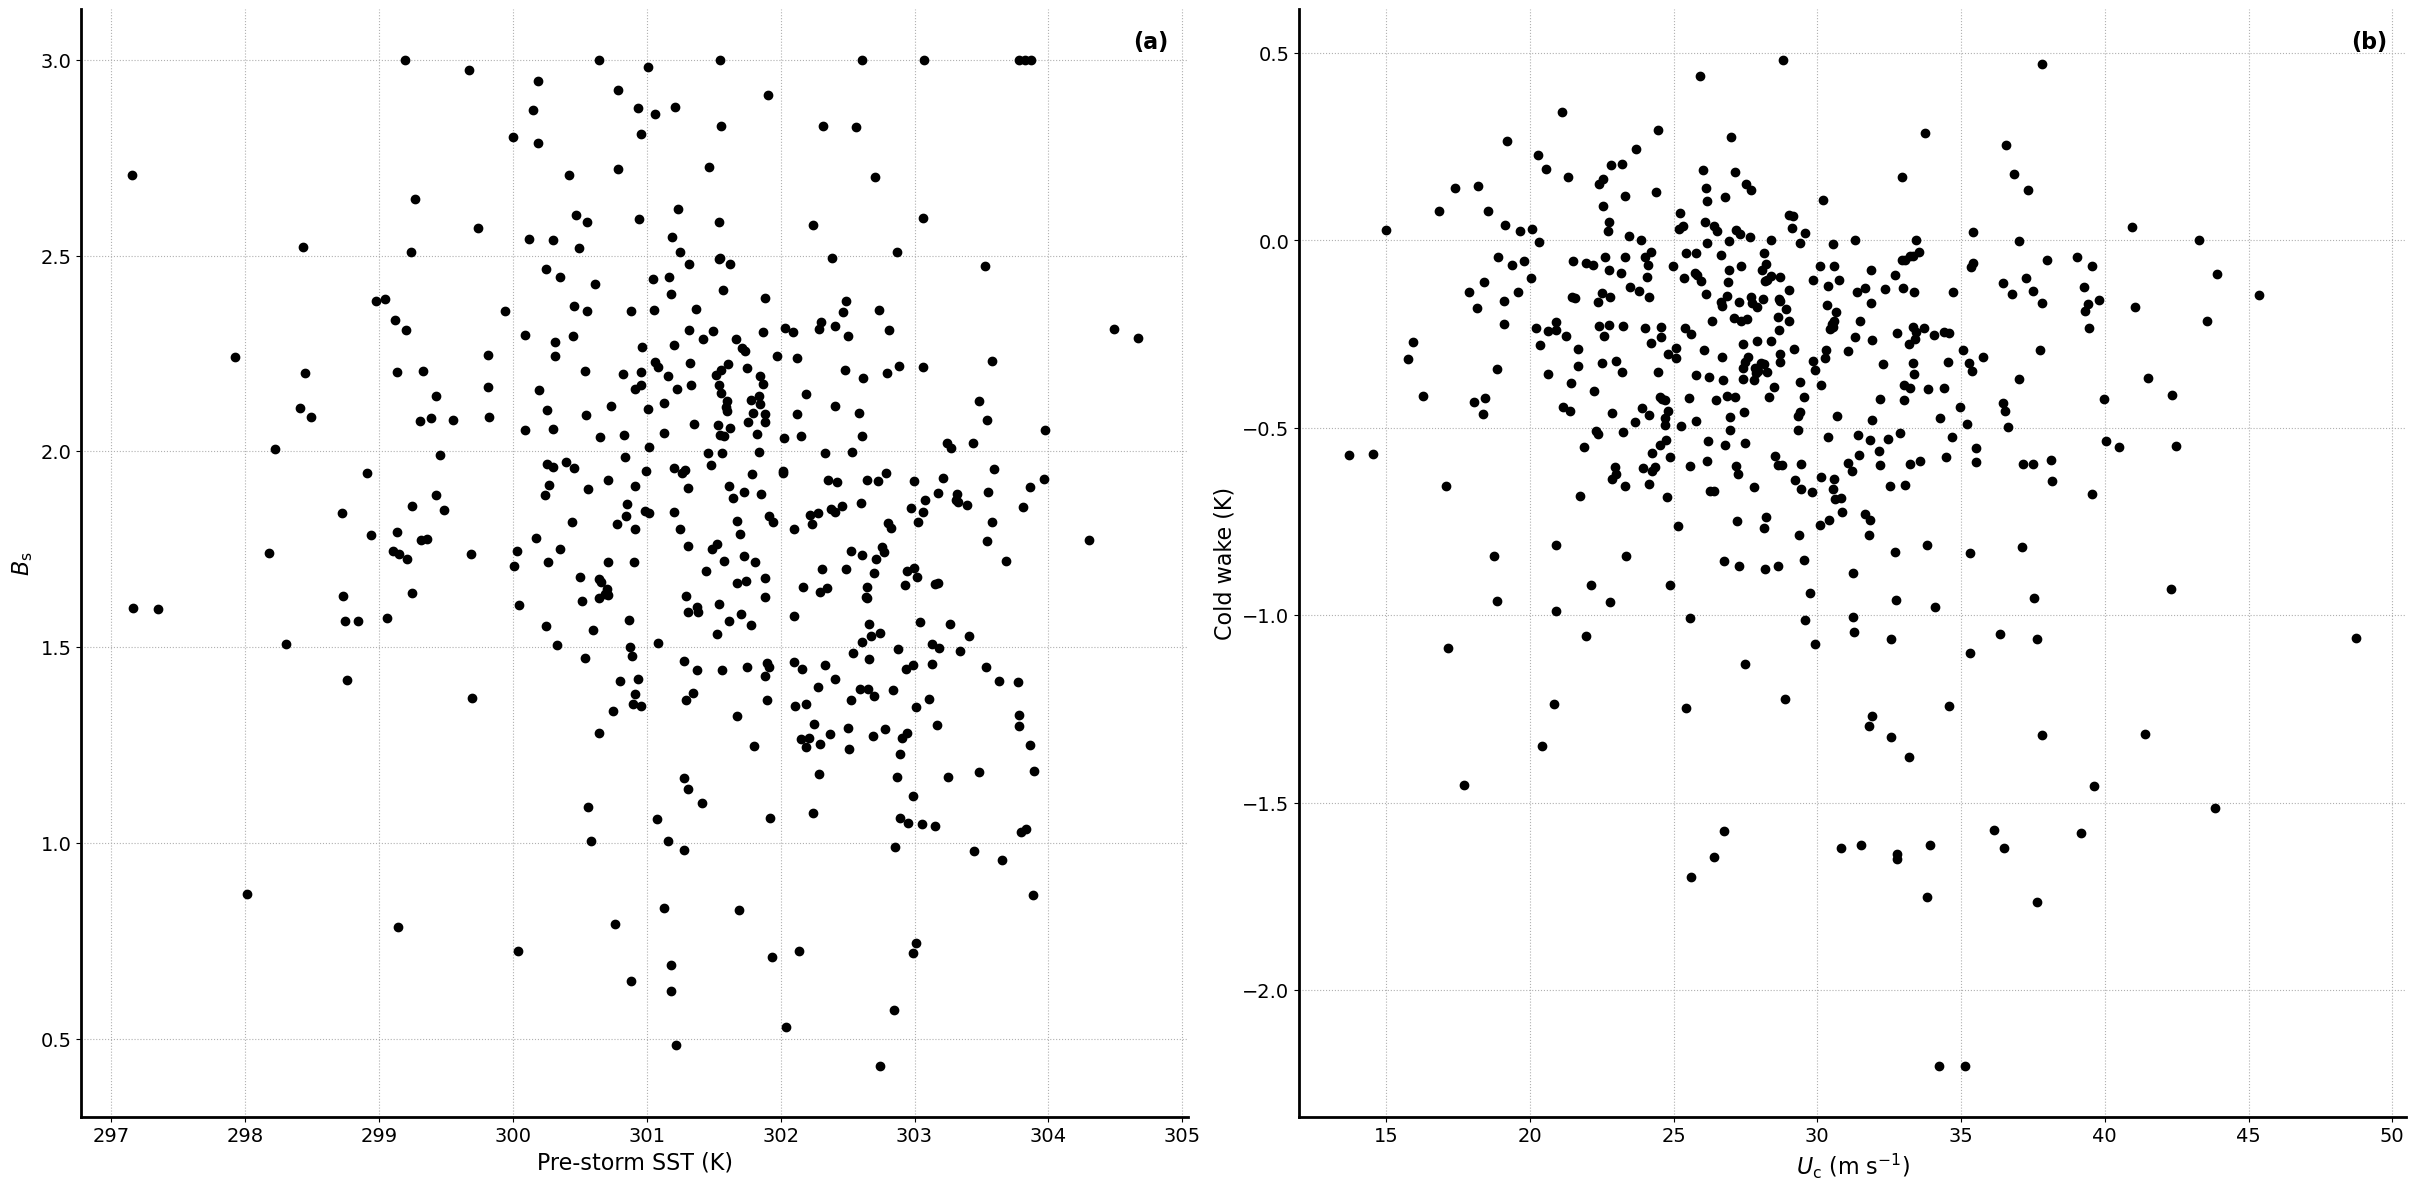

In [5]:
# Fig.
fig        = plt.figure(figsize=(30, 20))
gs         = GridSpec(1, 2, hspace=0.05, wspace=0.1, height_ratios=[1])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

ax.scatter(d.pre_sst_rms, d.B_hol, color='k')

# Labels
ax.set_xlabel('Pre-storm SST (K)')
ax.set_ylabel(r'$B_{\text{s}}$')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)


############
###  Uc  ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

ax.scatter(d.uc, d.cod_wak_rms, color='k')

# Labels
ax.set_xlabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_ylabel(r'Cold wake (K)')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)

# # Save
# plt.savefig(PTHS['sav_dir'] + 'diag_ocean.png', bbox_inches='tight')

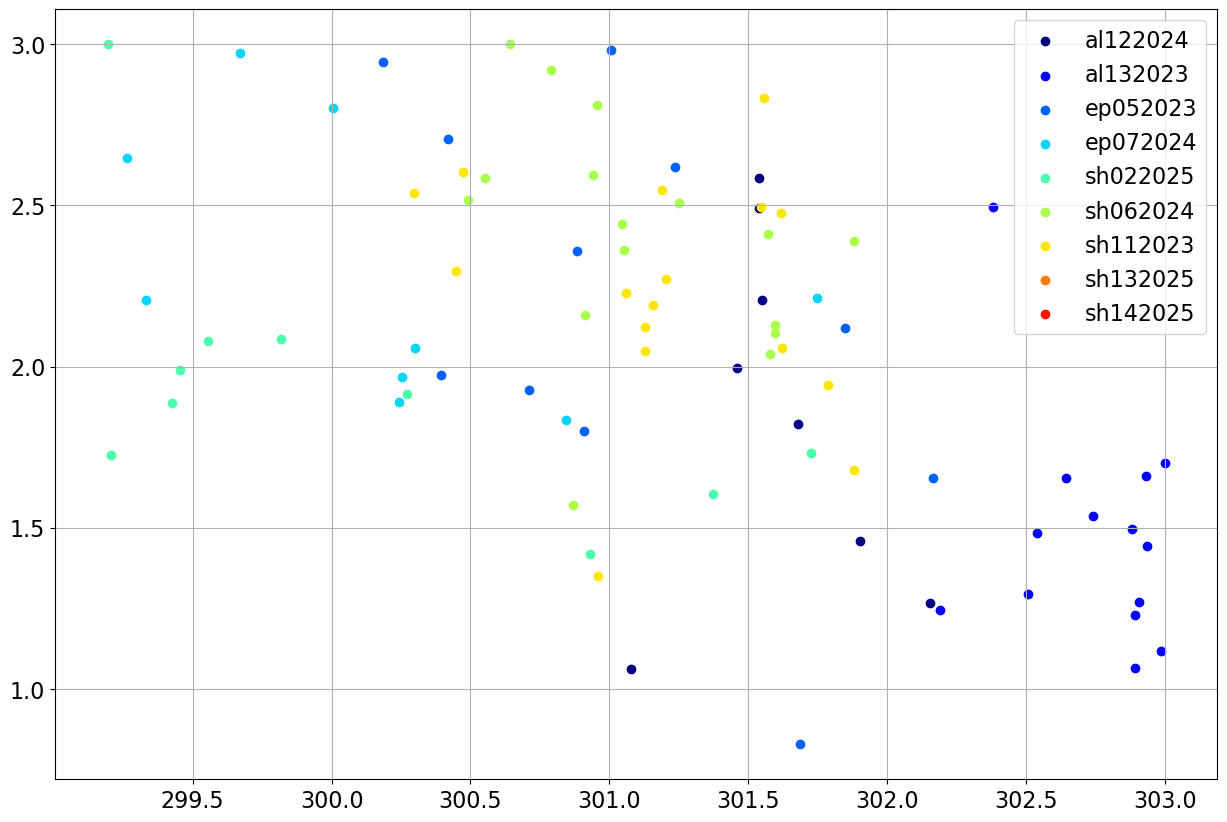

In [6]:
ids, cts  = np.unique(d.id, return_counts=True)
color_map = {unique_id: plt.cm.jet(i / len(ids[cts >= 8])) for i, unique_id in enumerate(ids[cts >= 8])}

for unique_id in ids[cts >= 8]:
    plt.scatter(d.where(d.id == unique_id, drop=True).pre_sst_rms, d.where(d.id == unique_id, drop=True).B_hol, color=color_map[unique_id], label=f'{unique_id}')
plt.grid()
plt.legend()

In [7]:
# ids, cts  = np.unique(d.id, return_counts=True)
# color_map = {unique_id: plt.cm.jet(i / len(ids[cts >= 8])) for i, unique_id in enumerate(ids[cts >= 8])}

# for unique_id in ids[cts >= 8]:
#     plt.scatter(d.where(d.id == unique_id, drop=True).pre_sst_rms, d.where(d.id == unique_id, drop=True).r34, color=color_map[unique_id], label=f'{unique_id}')
# plt.grid()
# plt.legend()

In [8]:
from scipy.stats import pearsonr

param1 = 'pre_sst_rms'
param2 = 'B_hol'

msk    = np.isnan(d[param1]) | np.isnan(d[param2])

# --- 1. Corrélation Totale ---
total_corr, _ = pearsonr(d[param1][~msk], d[param2][~msk])
print(f"Corrélation totale : {total_corr:.4f}")

# --- 2. Corrélation Intra-cluster ---
# Calcule la corrélation pour chaque cluster et fait la moyenne
intra_cluster_corrs = []
for unique_id in np.unique(d.id):
    subset = d.where(d['id'] == unique_id, drop=True)
    msk    = np.isnan(subset[param1]) | np.isnan(subset[param2])
    if len(subset.where(~msk).dropna(dim='time').time) >= 3: # Un cluster avec un seul point n'a pas de corrélation
        corr, _ = pearsonr(subset[param1][~msk], subset[param2][~msk])
        intra_cluster_corrs.append(corr)

intra_cluster_corr = np.mean(intra_cluster_corrs)
print(f"Corrélation intra-cluster (moyenne) : {intra_cluster_corr:.4f}")

# --- 3. Corrélation Inter-cluster ---
# Calcule la moyenne des paramètres pour chaque cluster, puis la corrélation
cluster_means = d.groupby('id').mean(dim='time')
msk    = np.isnan(cluster_means[param1]) | np.isnan(cluster_means[param2])
inter_cluster_corr, _ = pearsonr(cluster_means[param1][~msk], cluster_means[param2][~msk])
print(f"Corrélation inter-cluster : {inter_cluster_corr:.4f}")

Corrélation totale : -0.1879
Corrélation intra-cluster (moyenne) : -0.0307
Corrélation inter-cluster : -0.1860


In [9]:
# plt.hist(intra_cluster_corrs)

In [10]:
from scipy.stats import pearsonr

param1 = 'pre_sst_rms'
param2 = 'r34'

msk    = np.isnan(d[param1]) | np.isnan(d[param2])

# --- 1. Corrélation Totale ---
total_corr, _ = pearsonr(d[param1][~msk], d[param2][~msk])
print(f"Corrélation totale : {total_corr:.4f}")

# --- 2. Corrélation Intra-cluster ---
# Calcule la corrélation pour chaque cluster et fait la moyenne
intra_cluster_corrs = []
for unique_id in np.unique(d.id):
    subset = d.where(d['id'] == unique_id, drop=True)
    msk    = np.isnan(subset[param1]) | np.isnan(subset[param2])
    if len(subset.where(~msk).dropna(dim='time').time) >= 3: # Un cluster avec un seul point n'a pas de corrélation
        corr, _ = pearsonr(subset[param1][~msk], subset[param2][~msk])
        intra_cluster_corrs.append(corr)

intra_cluster_corr = np.mean(intra_cluster_corrs)
print(f"Corrélation intra-cluster (moyenne) : {intra_cluster_corr:.4f}")

# --- 3. Corrélation Inter-cluster ---
# Calcule la moyenne des paramètres pour chaque cluster, puis la corrélation
cluster_means = d.groupby('id').mean(dim='time')
msk    = np.isnan(cluster_means[param1]) | np.isnan(cluster_means[param2])
inter_cluster_corr, _ = pearsonr(cluster_means[param1][~msk], cluster_means[param2][~msk])
print(f"Corrélation inter-cluster : {inter_cluster_corr:.4f}")

Corrélation totale : 0.0790
Corrélation intra-cluster (moyenne) : -0.0680
Corrélation inter-cluster : 0.0670


In [11]:
# plt.hist(intra_cluster_corrs)

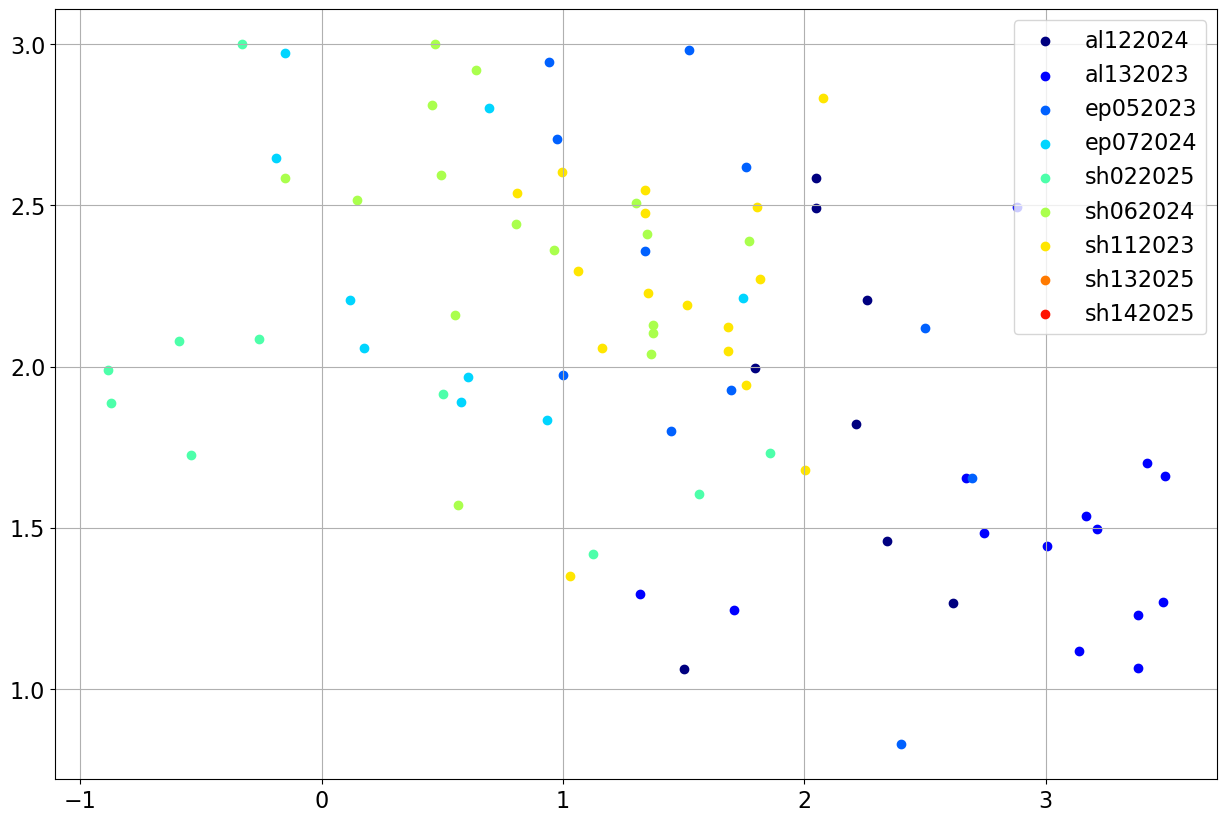

In [12]:
ids, cts  = np.unique(d.id, return_counts=True)
color_map = {unique_id: plt.cm.jet(i / len(ids[cts >= 8])) for i, unique_id in enumerate(ids[cts >= 8])}

for unique_id in ids[cts >= 8]:
    plt.scatter(d.where(d.id == unique_id, drop=True).rel_sst_rms, d.where(d.id == unique_id, drop=True).B_hol, color=color_map[unique_id], label=f'{unique_id}')
plt.grid()
plt.legend()

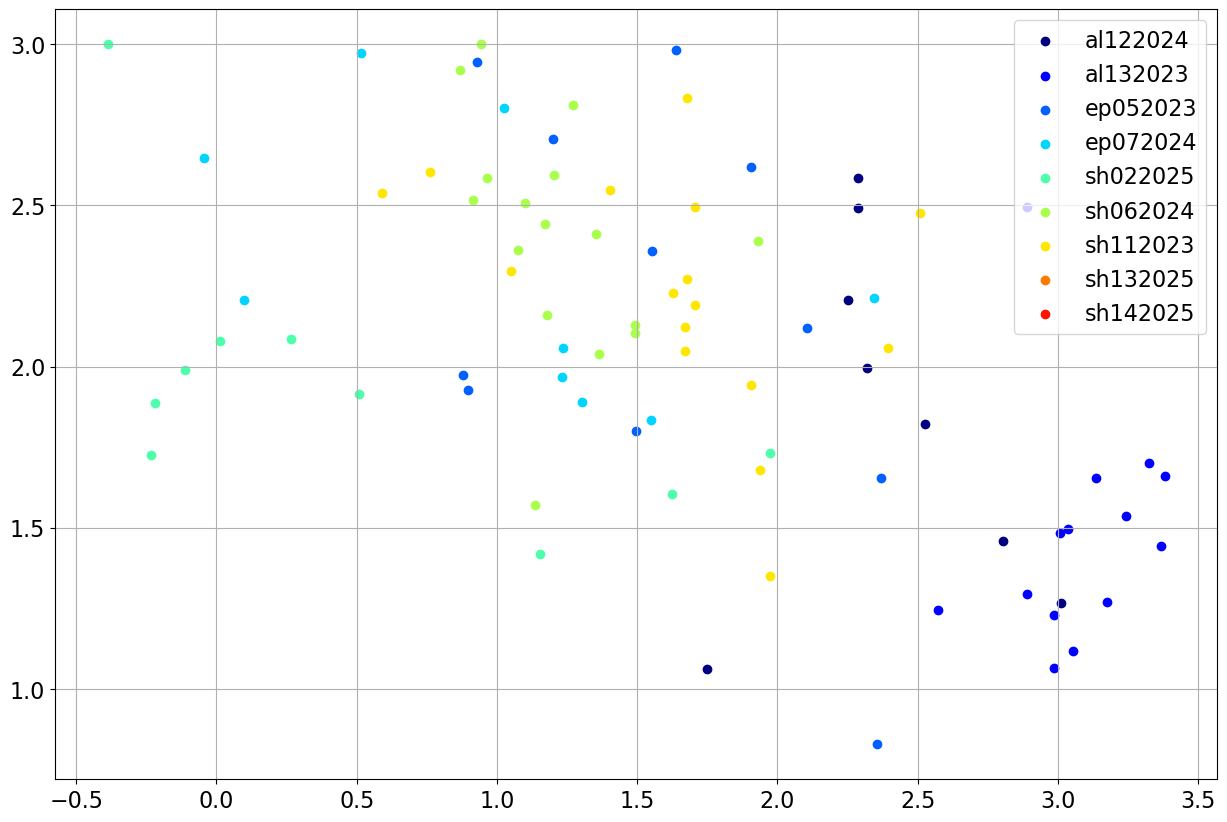

In [13]:
d['trop_sst'] = d.sst_rms - d.rel_sst_rms

ids, cts  = np.unique(d.id, return_counts=True)
color_map = {unique_id: plt.cm.jet(i / len(ids[cts >= 8])) for i, unique_id in enumerate(ids[cts >= 8])}

for unique_id in ids[cts >= 8]:
    plt.scatter(d.where(d.id == unique_id, drop=True).pre_sst_avg_rms - d.where(d.id == unique_id, drop=True).trop_sst, d.where(d.id == unique_id, drop=True).B_hol, color=color_map[unique_id], label=f'{unique_id}')
plt.grid()
plt.legend()

In [14]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### REFERENCE GRID
rs = np.linspace(0, 500000, 50001) # define dr accordingly

(0.0, 250.0)

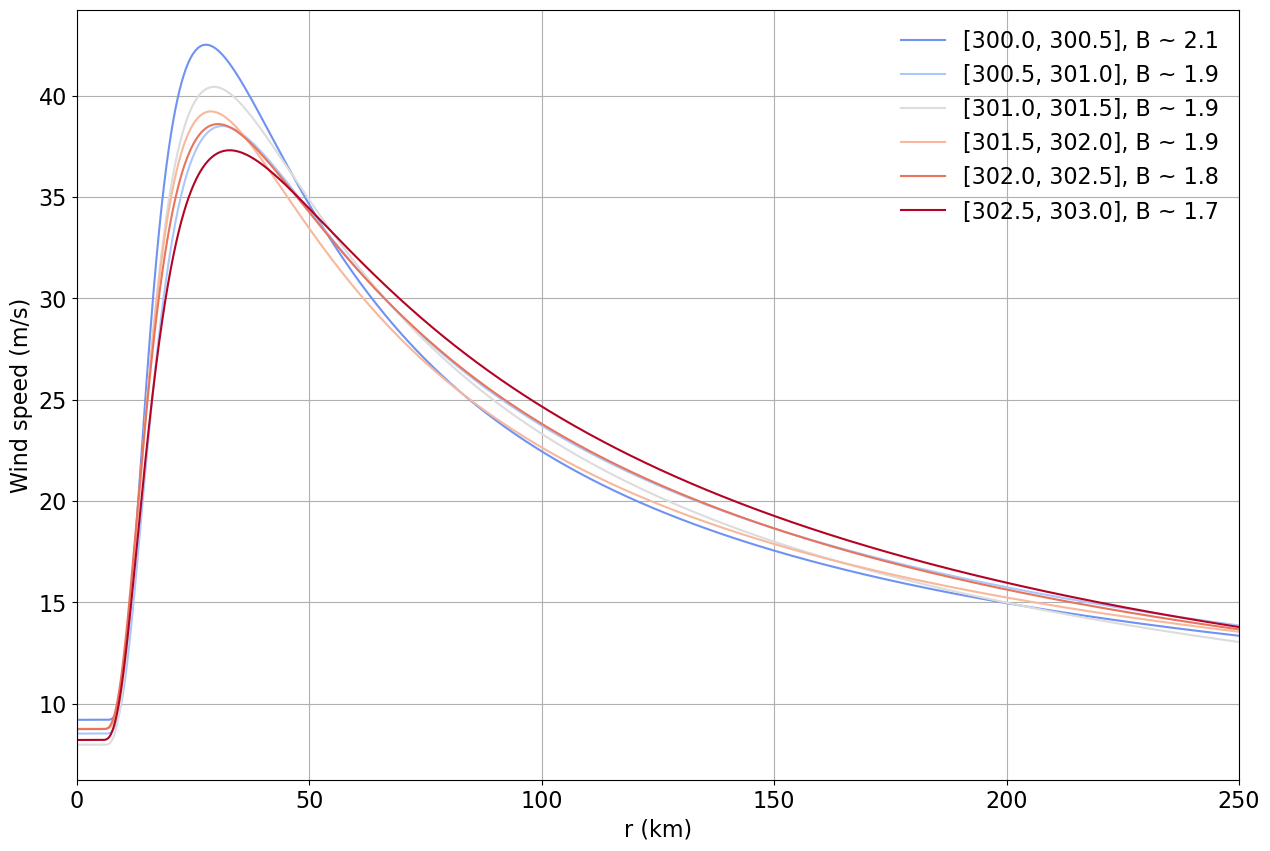

In [19]:
# bins      = [299, 300, 301, 302, 303, 304]
bins      = [300, 300.5, 301, 301.5, 302, 302.5, 303]
colors    = plt.cm.coolwarm(np.linspace(0, 1, len(bins)))

color_idx = 1
for interval, dd in d.groupby_bins(group='pre_sst_rms', bins=bins):
    Vh = holland_profile(rs, float(dd.lat.mean(dim='time', skipna=True)), float(dd.B_hol.mean(dim='time', skipna=True)), float(dd.vmn_hol.mean(dim='time', skipna=True)), float(dd.rmx_hol.mean(dim='time', skipna=True)), float(dd.vmx_hol.mean(dim='time', skipna=True)))
    plt.plot(rs / 1000, Vh, label='[{:.1f}, {:.1f}], B ~ {:.1f}'.format(interval.left, interval.right, float(dd.B_hol.mean(dim='time', skipna=True))), color=colors[color_idx])
    color_idx += 1
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r (km)')
plt.ylabel('Wind speed (m/s)')
plt.xlim(0, 250)

(0.0, 250.0)

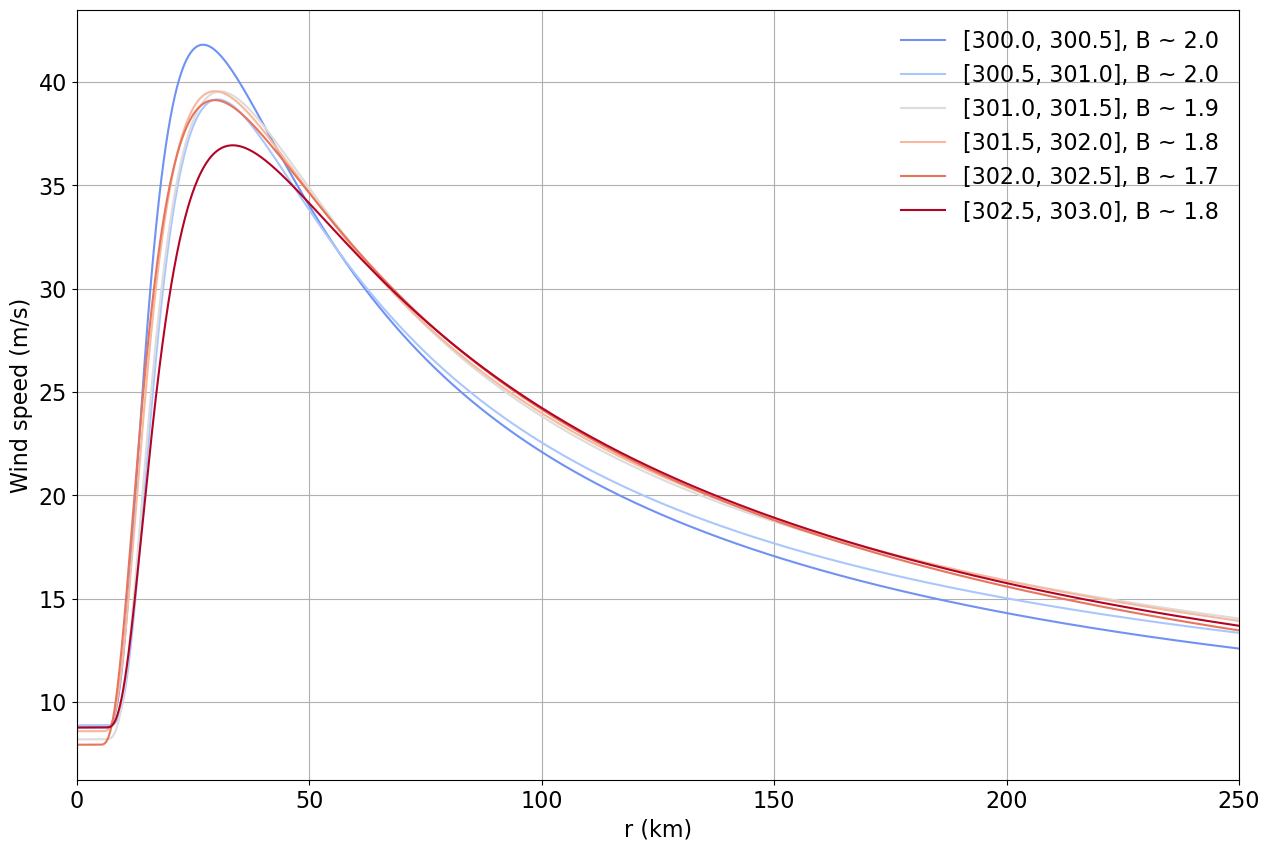

In [20]:
# bins      = [299, 300, 301, 302, 303, 304]
bins      = [300, 300.5, 301, 301.5, 302, 302.5, 303]
colors    = plt.cm.coolwarm(np.linspace(0, 1, len(bins)))

color_idx = 1
for interval, dd in d.groupby_bins(group='pre_sst_avg_rms', bins=bins):
    Vh = holland_profile(rs, float(dd.lat.mean(dim='time', skipna=True)), float(dd.B_hol.mean(dim='time', skipna=True)), float(dd.vmn_hol.mean(dim='time', skipna=True)), float(dd.rmx_hol.mean(dim='time', skipna=True)), float(dd.vmx_hol.mean(dim='time', skipna=True)))
    plt.plot(rs / 1000, Vh, label='[{:.1f}, {:.1f}], B ~ {:.1f}'.format(interval.left, interval.right, float(dd.B_hol.mean(dim='time', skipna=True))), color=colors[color_idx])
    color_idx += 1
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r (km)')
plt.ylabel('Wind speed (m/s)')
plt.xlim(0, 250)

(0.0, 250.0)

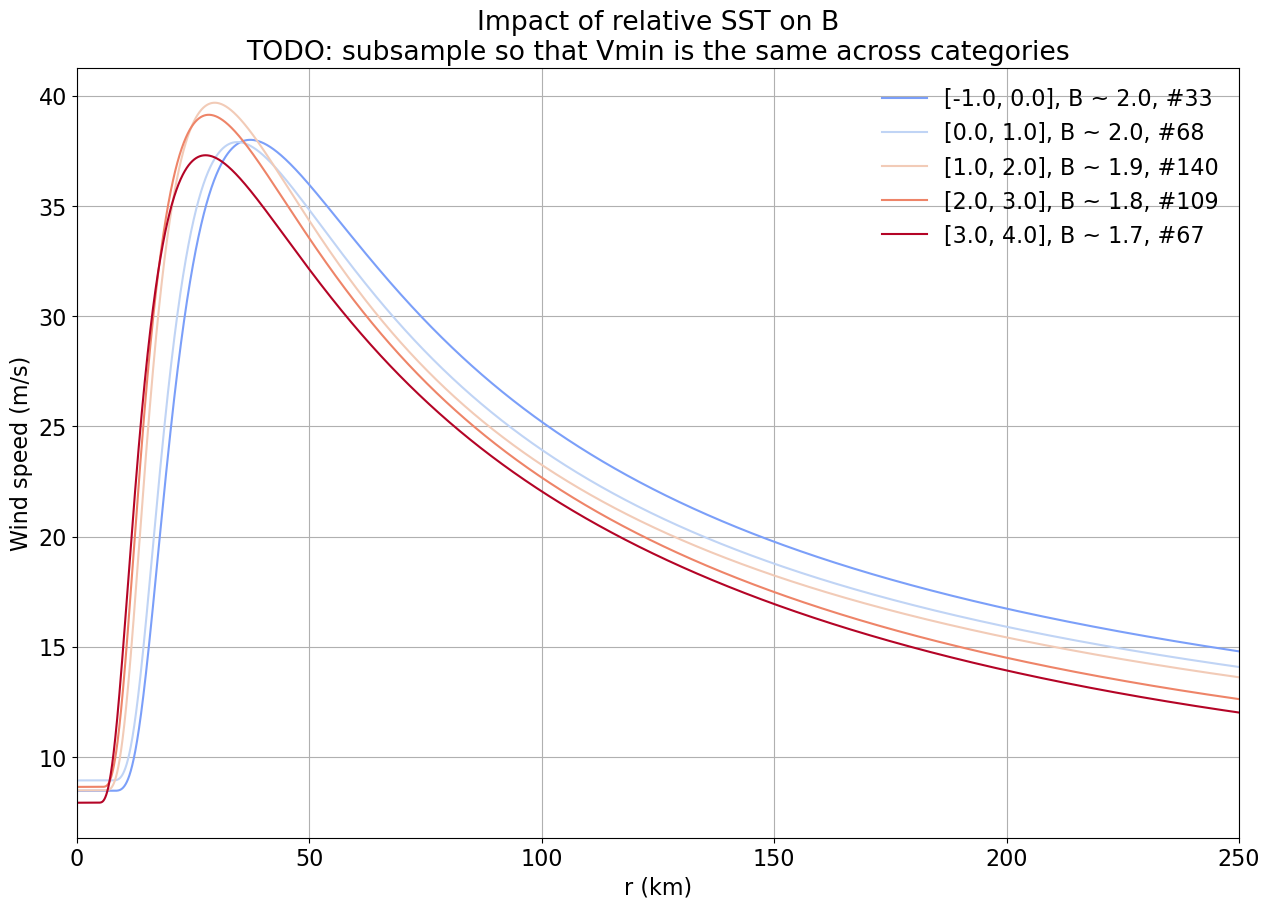

In [28]:
bins      = [-1, 0, 1, 2, 3, 4]
# bins      = [-1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
colors    = plt.cm.coolwarm(np.linspace(0, 1, len(bins)))

# Plot
plt.title('Impact of relative SST on B\nTODO: subsample so that Vmin is the same across categories')

color_idx = 1
for interval, dd in d.groupby_bins(group='rel_sst_rms', bins=bins):
    Vh = holland_profile(rs, float(dd.lat.mean(dim='time', skipna=True)), float(dd.B_hol.mean(dim='time', skipna=True)), float(dd.vmn_hol.mean(dim='time', skipna=True)), float(dd.rmx_hol.mean(dim='time', skipna=True)), float(dd.vmx_hol.mean(dim='time', skipna=True)))
    plt.plot(rs / 1000, Vh, label='[{:.1f}, {:.1f}], B ~ {:.1f}, #{:.0f}'.format(interval.left, interval.right, float(dd.B_hol.mean(dim='time', skipna=True)), len(dd.time)), color=colors[color_idx])
    color_idx += 1
plt.legend(frameon=False)
plt.grid()
plt.xlabel('r (km)')
plt.ylabel('Wind speed (m/s)')
plt.xlim(0, 250)

In [30]:
# # Créez des intervalles (strates) pour la variable vmn_hol
# # Vous pouvez ajuster ces intervalles en fonction de la distribution de vos données
# vmn_bins = [0, 2, 4, 6, 8, 10, 12] 
# vmn_labels = [f'{b}-{vmn_bins[i+1]}' for i, b in enumerate(vmn_bins[:-1])]

# # Définissez le nombre d'échantillons à prélever par strate dans chaque sous-groupe
# n_per_strata = 5  # 5 échantillons * 6 strates = 30 échantillons au total

# # Votre code
# bins = [-1, 0, 1, 2, 3, 4]
# colors = plt.cm.coolwarm(np.linspace(0, 1, len(bins)))

# # Plot
# plt.title('Impact of relative SST on B\nSubsampled with 30 items & equal Vmin distribution')

# color_idx = 1
# for interval, dd_group in d.groupby_bins(group='rel_sst_rms', bins=bins):
    
#     # 1. Créez les strates pour vmn_hol dans ce sous-groupe
#     dd_group['vmn_strata'] = pd.cut(dd_group['vmn_hol'], bins=vmn_bins, labels=vmn_labels, right=False)
    
#     # 2. Sous-échantillonnez de manière stratifiée
#     # S'il y a assez d'échantillons pour chaque strate, on sous-échantillonne
#     if all(len(g) >= n_per_strata for name, g in dd_group.groupby('vmn_strata')):
#         dd_subsampled = dd_group.groupby('vmn_strata').apply(lambda x: x.sample(n=n_per_strata, replace=False))
#     else:
#         # S'il n'y a pas assez de données pour faire un sous-échantillonnage stratifié,
#         # on peut soit ignorer le groupe, soit le sous-échantillonner aléatoirement
#         print(f"Groupe {interval} : Pas assez de données pour un sous-échantillonnage stratifié. Ignoré.")
#         continue # Passer au groupe suivant
        
#     # 3. Supprimez la colonne temporaire
#     dd_subsampled = dd_subsampled.reset_index(drop=True)

#     # 4. Effectuez le tracé avec le sous-échantillon stratifié
#     Vh = holland_profile(rs, float(dd_subsampled.lat.mean(dim='time', skipna=True)), 
#                          float(dd_subsampled.B_hol.mean(dim='time', skipna=True)), 
#                          float(dd_subsampled.vmn_hol.mean(dim='time', skipna=True)), 
#                          float(dd_subsampled.rmx_hol.mean(dim='time', skipna=True)), 
#                          float(dd_subsampled.vmx_hol.mean(dim='time', skipna=True)))
    
#     plt.plot(rs / 1000, Vh, 
#              label='[{:.1f}, {:.1f}], B ~ {:.1f}, #{:.0f}'.format(
#                  interval.left, interval.right, 
#                  float(dd_subsampled.B_hol.mean(dim='time', skipna=True)), 
#                  len(dd_subsampled.time)), 
#              color=colors[color_idx])
    
#     color_idx += 1

# plt.legend(frameon=False)
# plt.grid()
# plt.xlabel('r (km)')
# plt.ylabel('Wind speed (m/s)')
# plt.xlim(0, 250)

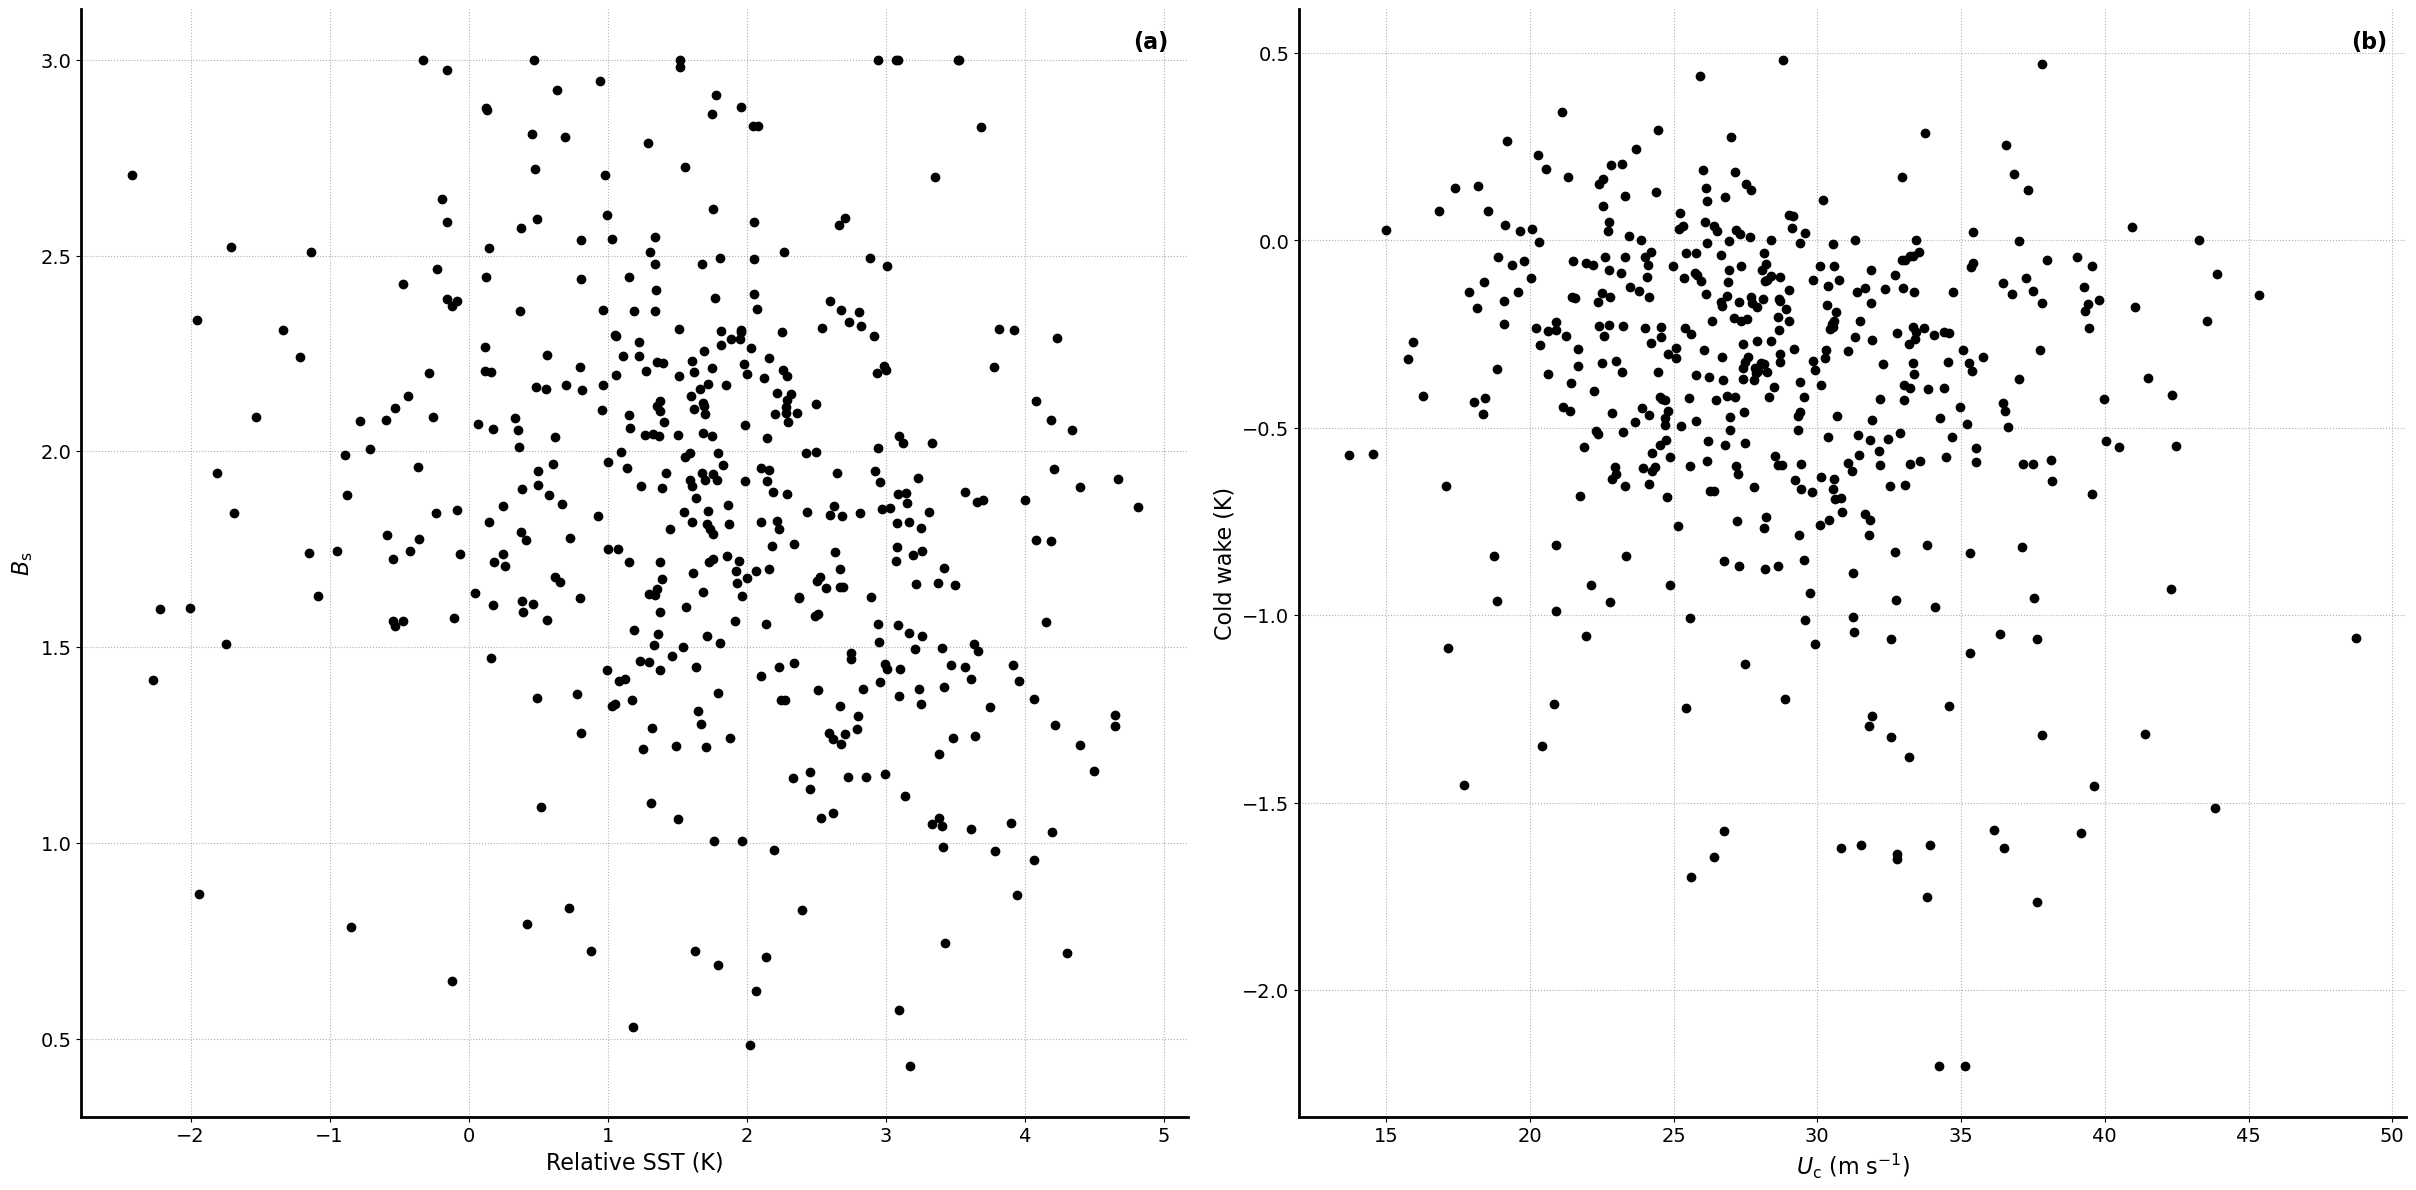

In [22]:
# Fig.
fig        = plt.figure(figsize=(30, 20))
gs         = GridSpec(1, 2, hspace=0.05, wspace=0.1, height_ratios=[1])

############
###  Bs  ###
############
ax = fig.add_subplot(gs[0, 0])
ax.text(0.95, 0.965, '(a)', transform=ax.transAxes, weight='bold')

ax.scatter(d.rel_sst_rms, d.B_hol, color='k')
# ax.scatter(d.where(d.pre_sss_rms < 34, drop=True).rel_sst_rms, d.where(d.pre_sss_rms < 34, drop=True).B_hol, color='r')

# Labels
ax.set_xlabel('Relative SST (K)')
ax.set_ylabel(r'$B_{\text{s}}$')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)


############
###  Uc  ###
############
ax = fig.add_subplot(gs[0, 1])
ax.text(0.95, 0.965, '(b)', transform=ax.transAxes, weight='bold')

ax.scatter(d.uc, d.cod_wak_rms, color='k')

# Labels
ax.set_xlabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_ylabel(r'Cold wake (K)')
plt.xticks(fontsize=fontsize - 2) #the x-ticks 
plt.yticks(fontsize=fontsize - 2) #the y-ticks 

# Grids
# Frame for the plot (do this after the right label position otherwise missing ticks)
ax.spines['left'].set_linewidth(2) #set the width of axis lines -> version without loop
ax.spines['bottom'].set_linewidth(2)
ax.spines[['right', 'top']].set_visible(False)
ax.grid(ls=':')
ax.set_axisbelow(True) # Set the grid in background
ax.set_box_aspect(1)

# # Save
# plt.savefig(PTHS['sav_dir'] + 'diag_ocean.png', bbox_inches='tight')

### 2) How parameters impact B

Pour une SST donnée, B décroît en moyenne avec la latitude. 

B augmente au premier ordre avec Vmin. Le reste c'est du second ordre par rapport à ça.

Légère diminution de Vmin avec la SST. Donc mon B décroissant avec la SST pourrait venir surtout de ça !!

In [15]:
# plt.scatter(d.sst_rms, d.B_hol, c=abs(d.lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
# plt.grid()
# plt.colorbar()
# plt.show()

# plt.scatter(d.vmn_hol, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
# plt.colorbar()
# plt.show()

# plt.scatter(d.rmx_hol, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
# plt.colorbar()
# plt.show()

# plt.scatter(d.vmx_hol, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
# plt.colorbar()
# plt.show()

# plt.scatter(abs(d.fcor), d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
# plt.colorbar()
# plt.show()

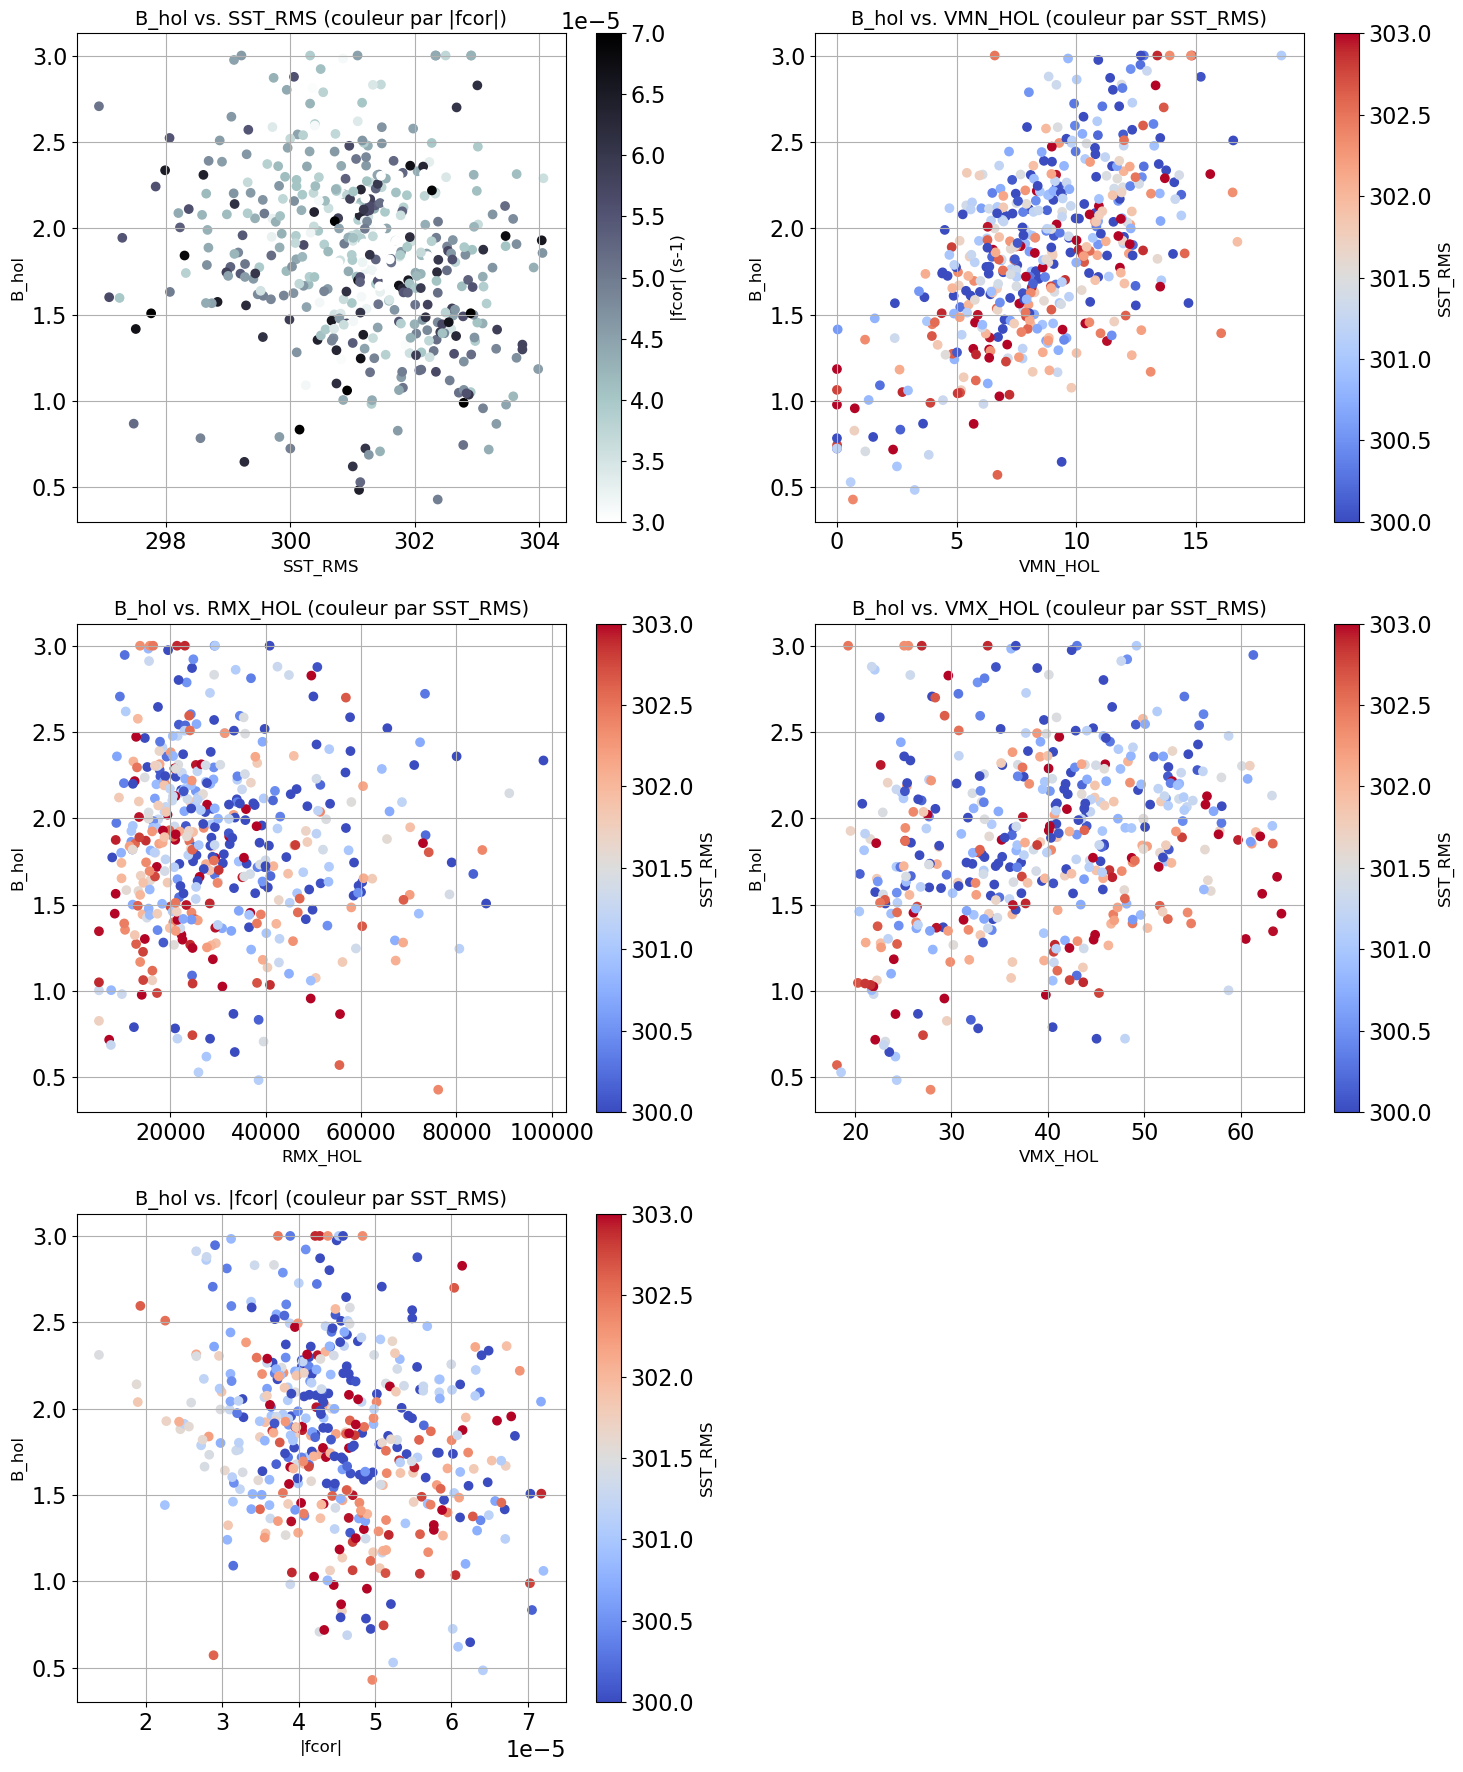

In [16]:
# Créez la figure et les subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18)) # 3 lignes, 2 colonnes, ajustez la taille au besoin
axes = axes.flatten() # Pour faciliter l'itération sur les axes

# 1er subplot: sst_rms vs B_hol
sc1 = axes[0].scatter(d.sst_rms, d.B_hol, c=abs(d.fcor), vmin=3e-5, vmax=7e-5, cmap=plt.get_cmap('bone_r'))
axes[0].set_title('B_hol vs. SST_RMS (couleur par |fcor|)', fontsize=14)
axes[0].set_xlabel('SST_RMS', fontsize=12)
axes[0].set_ylabel('B_hol', fontsize=12)
axes[0].grid(True)
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label('|fcor| (s-1)', fontsize=12)

# 2ème subplot: vmn_hol vs B_hol
sc2 = axes[1].scatter(d.vmn_hol, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[1].set_title('B_hol vs. VMN_HOL (couleur par SST_RMS)', fontsize=14)
axes[1].set_xlabel('VMN_HOL', fontsize=12)
axes[1].set_ylabel('B_hol', fontsize=12)
axes[1].grid(True)
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label('SST_RMS', fontsize=12)

# 3ème subplot: rmx_hol vs B_hol
sc3 = axes[2].scatter(d.rmx_hol, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[2].set_title('B_hol vs. RMX_HOL (couleur par SST_RMS)', fontsize=14)
axes[2].set_xlabel('RMX_HOL', fontsize=12)
axes[2].set_ylabel('B_hol', fontsize=12)
axes[2].grid(True)
cbar3 = fig.colorbar(sc3, ax=axes[2])
cbar3.set_label('SST_RMS', fontsize=12)

# 4ème subplot: vmx_hol vs B_hol
sc4 = axes[3].scatter(d.vmx_hol, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[3].set_title('B_hol vs. VMX_HOL (couleur par SST_RMS)', fontsize=14)
axes[3].set_xlabel('VMX_HOL', fontsize=12)
axes[3].set_ylabel('B_hol', fontsize=12)
axes[3].grid(True)
cbar4 = fig.colorbar(sc4, ax=axes[3])
cbar4.set_label('SST_RMS', fontsize=12)

# 5ème subplot: abs(fcor) vs B_hol
sc5 = axes[4].scatter(abs(d.fcor), d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[4].set_title('B_hol vs. |fcor| (couleur par SST_RMS)', fontsize=14)
axes[4].set_xlabel('|fcor|', fontsize=12)
axes[4].set_ylabel('B_hol', fontsize=12)
axes[4].grid(True)
cbar5 = fig.colorbar(sc5, ax=axes[4])
cbar5.set_label('SST_RMS', fontsize=12)

# Masquer le dernier subplot vide si nécessaire (il y en a 6 au total, 5 sont utilisés)
if len(axes) > 5:
    fig.delaxes(axes[5])

# Ajustez l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()

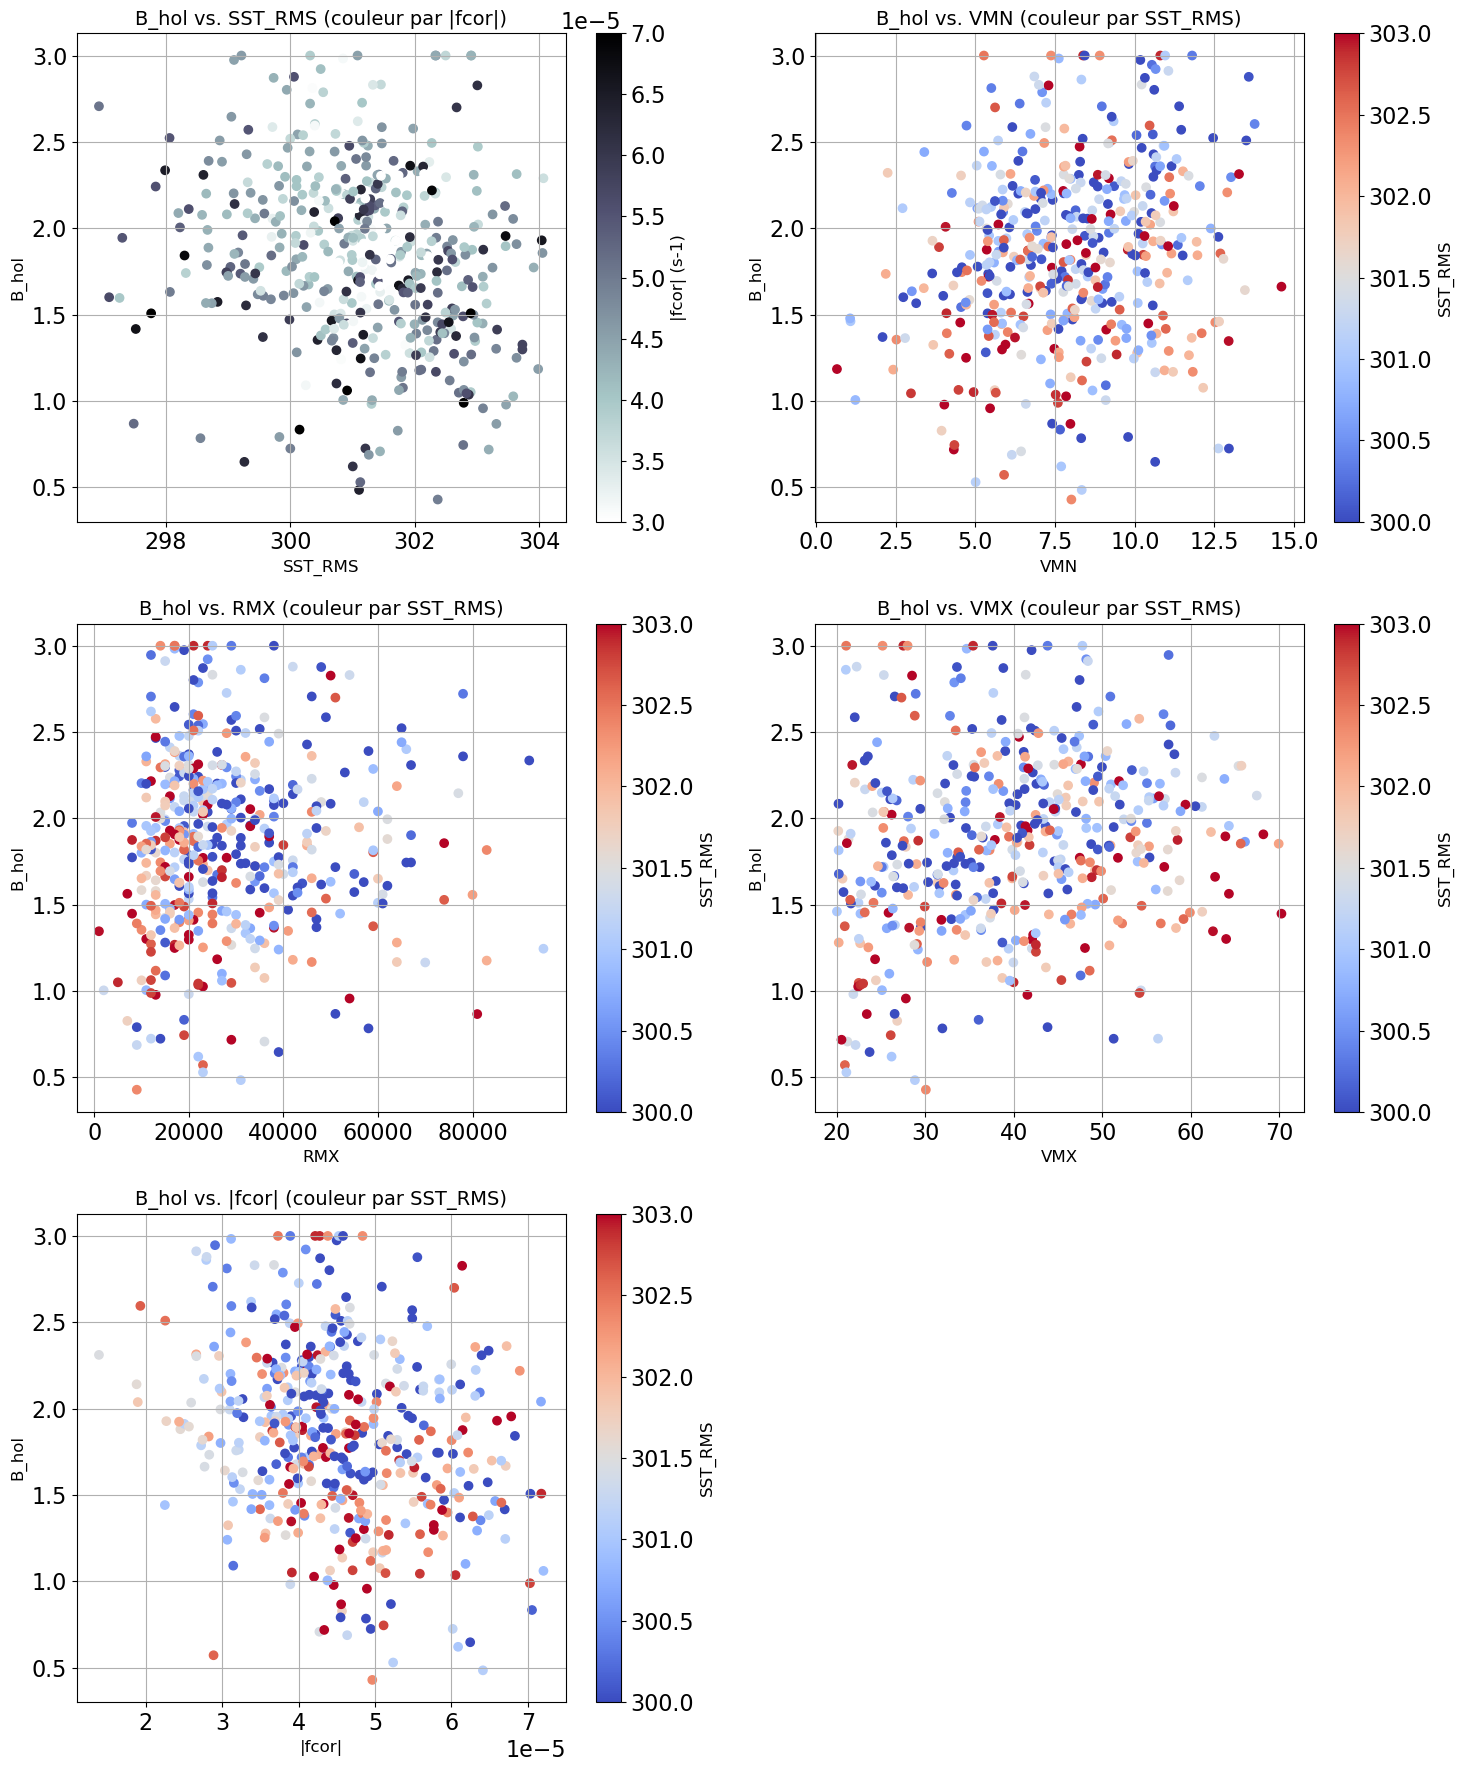

In [31]:
# Créez la figure et les subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18)) # 3 lignes, 2 colonnes, ajustez la taille au besoin
axes = axes.flatten() # Pour faciliter l'itération sur les axes

# 1er subplot: sst_rms vs B_hol
sc1 = axes[0].scatter(d.sst_rms, d.B_hol, c=abs(d.fcor), vmin=3e-5, vmax=7e-5, cmap=plt.get_cmap('bone_r'))
axes[0].set_title('B_hol vs. SST_RMS (couleur par |fcor|)', fontsize=14)
axes[0].set_xlabel('SST_RMS', fontsize=12)
axes[0].set_ylabel('B_hol', fontsize=12)
axes[0].grid(True)
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label('|fcor| (s-1)', fontsize=12)

# 2ème subplot: vmn_hol vs B_hol
sc2 = axes[1].scatter(d.vmn, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[1].set_title('B_hol vs. VMN (couleur par SST_RMS)', fontsize=14)
axes[1].set_xlabel('VMN', fontsize=12)
axes[1].set_ylabel('B_hol', fontsize=12)
axes[1].grid(True)
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label('SST_RMS', fontsize=12)

# 3ème subplot: rmx_hol vs B_hol
sc3 = axes[2].scatter(d.rmx, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[2].set_title('B_hol vs. RMX (couleur par SST_RMS)', fontsize=14)
axes[2].set_xlabel('RMX', fontsize=12)
axes[2].set_ylabel('B_hol', fontsize=12)
axes[2].grid(True)
cbar3 = fig.colorbar(sc3, ax=axes[2])
cbar3.set_label('SST_RMS', fontsize=12)

# 4ème subplot: vmx_hol vs B_hol
sc4 = axes[3].scatter(d.vmx, d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[3].set_title('B_hol vs. VMX (couleur par SST_RMS)', fontsize=14)
axes[3].set_xlabel('VMX', fontsize=12)
axes[3].set_ylabel('B_hol', fontsize=12)
axes[3].grid(True)
cbar4 = fig.colorbar(sc4, ax=axes[3])
cbar4.set_label('SST_RMS', fontsize=12)

# 5ème subplot: abs(fcor) vs B_hol
sc5 = axes[4].scatter(abs(d.fcor), d.B_hol, c=d.sst_rms, vmin=300, vmax=303, cmap=plt.get_cmap('coolwarm'))
axes[4].set_title('B_hol vs. |fcor| (couleur par SST_RMS)', fontsize=14)
axes[4].set_xlabel('|fcor|', fontsize=12)
axes[4].set_ylabel('B_hol', fontsize=12)
axes[4].grid(True)
cbar5 = fig.colorbar(sc5, ax=axes[4])
cbar5.set_label('SST_RMS', fontsize=12)

# Masquer le dernier subplot vide si nécessaire (il y en a 6 au total, 5 sont utilisés)
if len(axes) > 5:
    fig.delaxes(axes[5])

# Ajustez l'espacement entre les subplots pour éviter le chevauchement
plt.tight_layout()
plt.show()

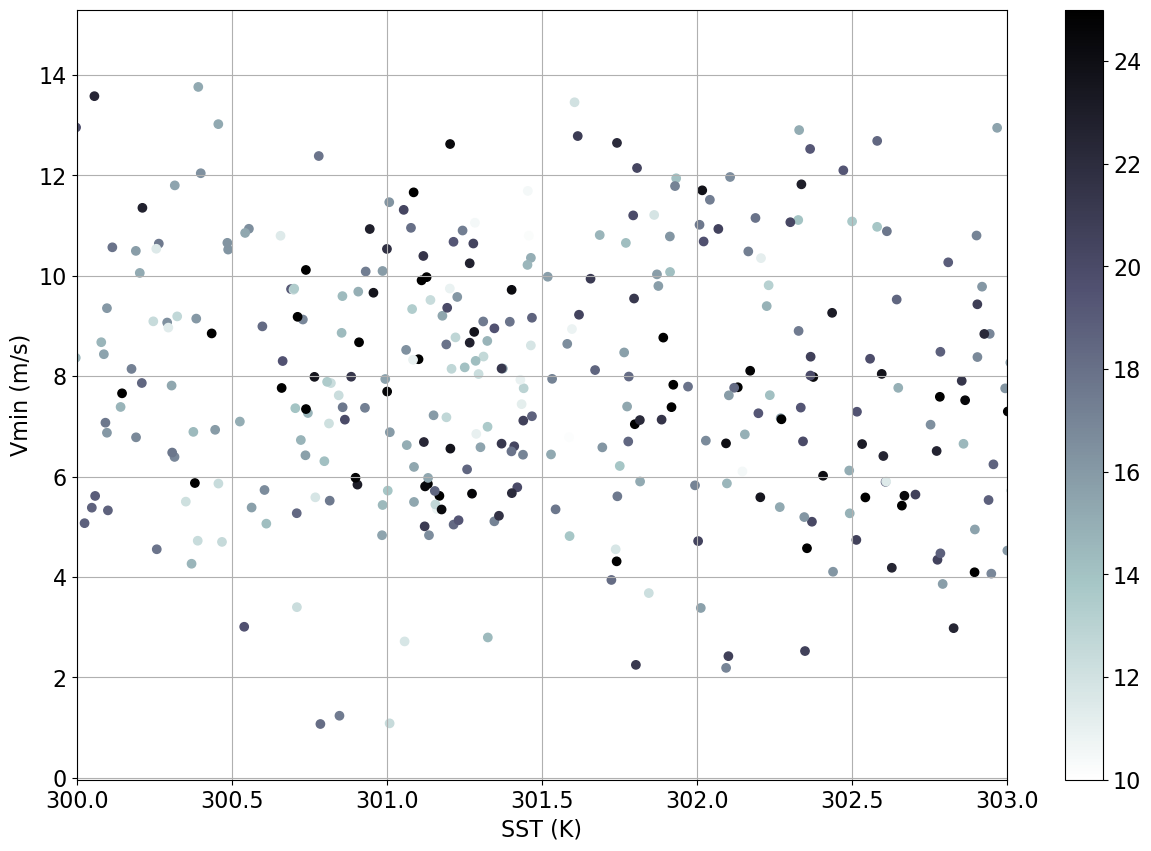

In [99]:
plt.scatter(d.sst_rms, d.vmn, c=abs(d.lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
plt.xlim(300, 303)
plt.grid()
plt.xlabel('SST (K)')
plt.ylabel('Vmin (m/s)')
plt.colorbar()

### 3) How other parameters are affected by SST

Pour 24 points qui ont (à peu près) le même Vmax, Uc, et Rossby, la relation B = f(SST) décroissante est conservée, mais encore bien bruitée. 

Si je colorie par t_since_lmi_ibt, la relation devient un peu plus claire pour ces 24 points.

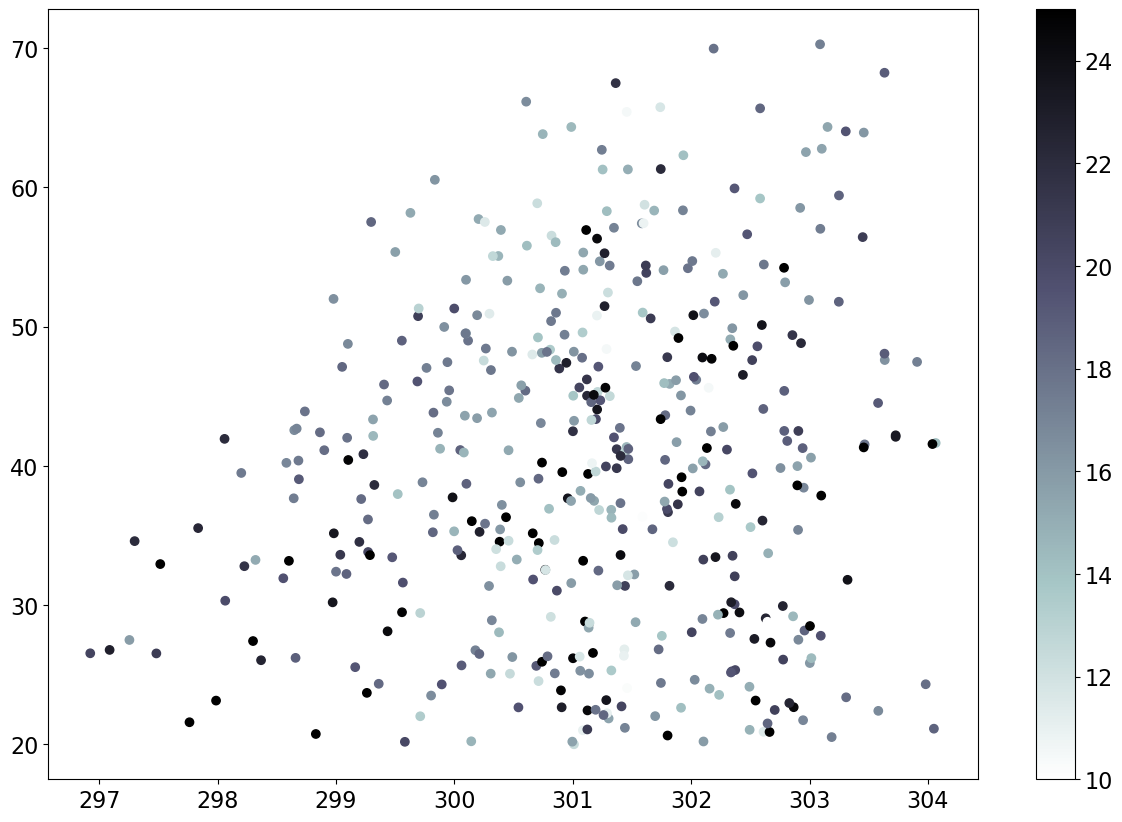

In [39]:
plt.scatter(d.sst_rms, d.vmx, c=abs(d.lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
plt.colorbar()

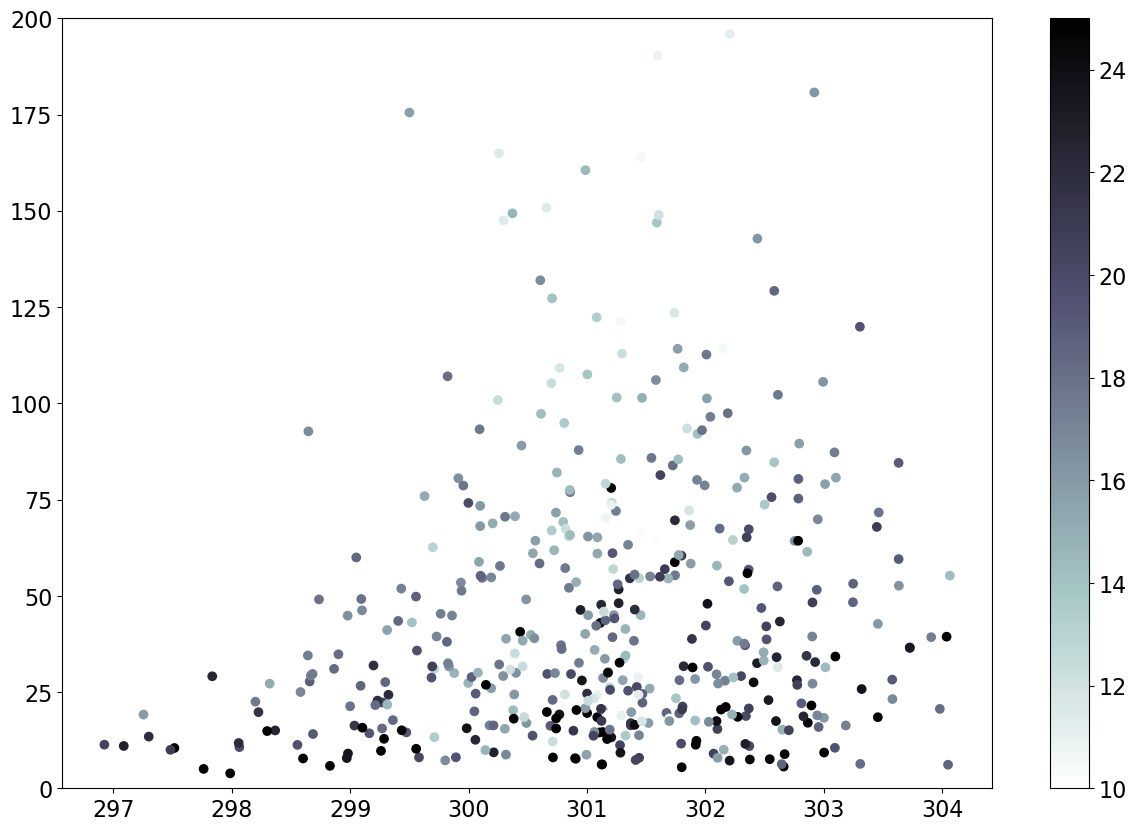

In [40]:
plt.scatter(d.sst_rms, d.rsby, c=abs(d.lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
plt.ylim(0, 200)
plt.colorbar()

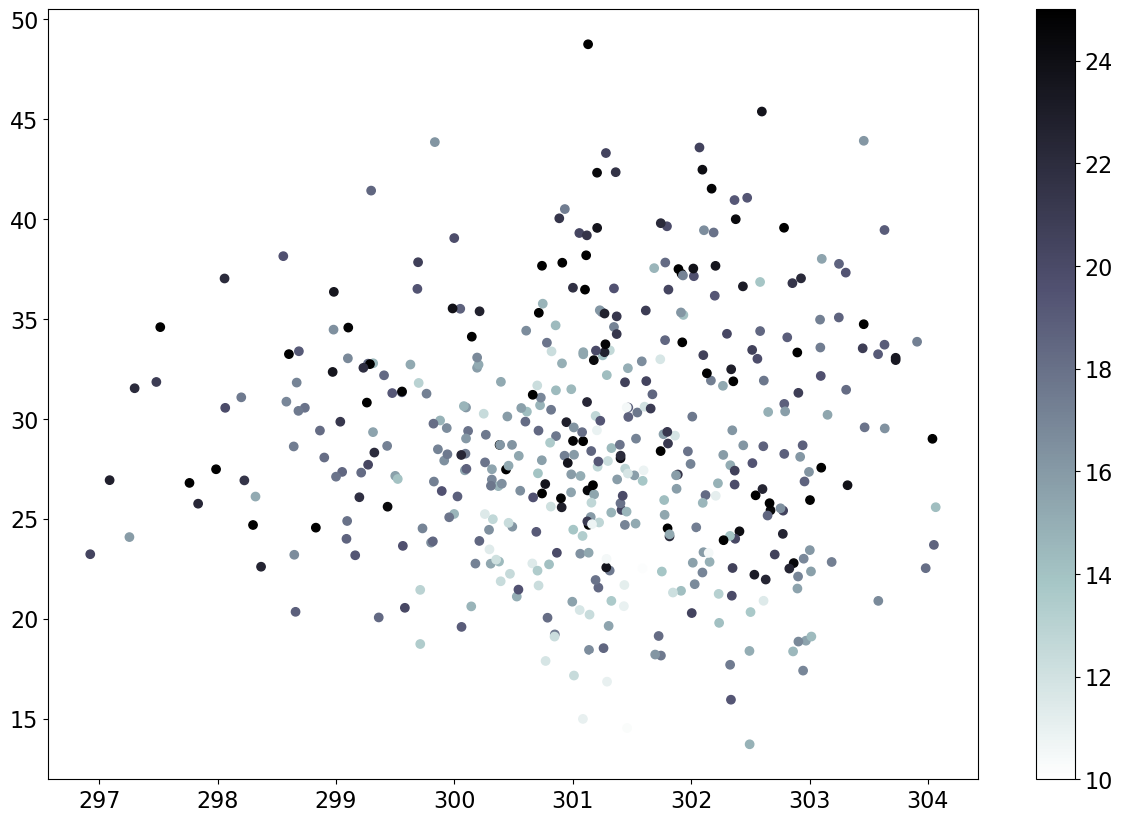

In [41]:
plt.scatter(d.sst_rms, d.uc, c=abs(d.lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
# plt.ylim(0, 200)
plt.colorbar()

In [60]:
dd = d.where((abs(d.vmx - 47.5) <= 2.5) & (abs(d.uc - 30) < 2.5) & (d.rsby < 75), drop=True)

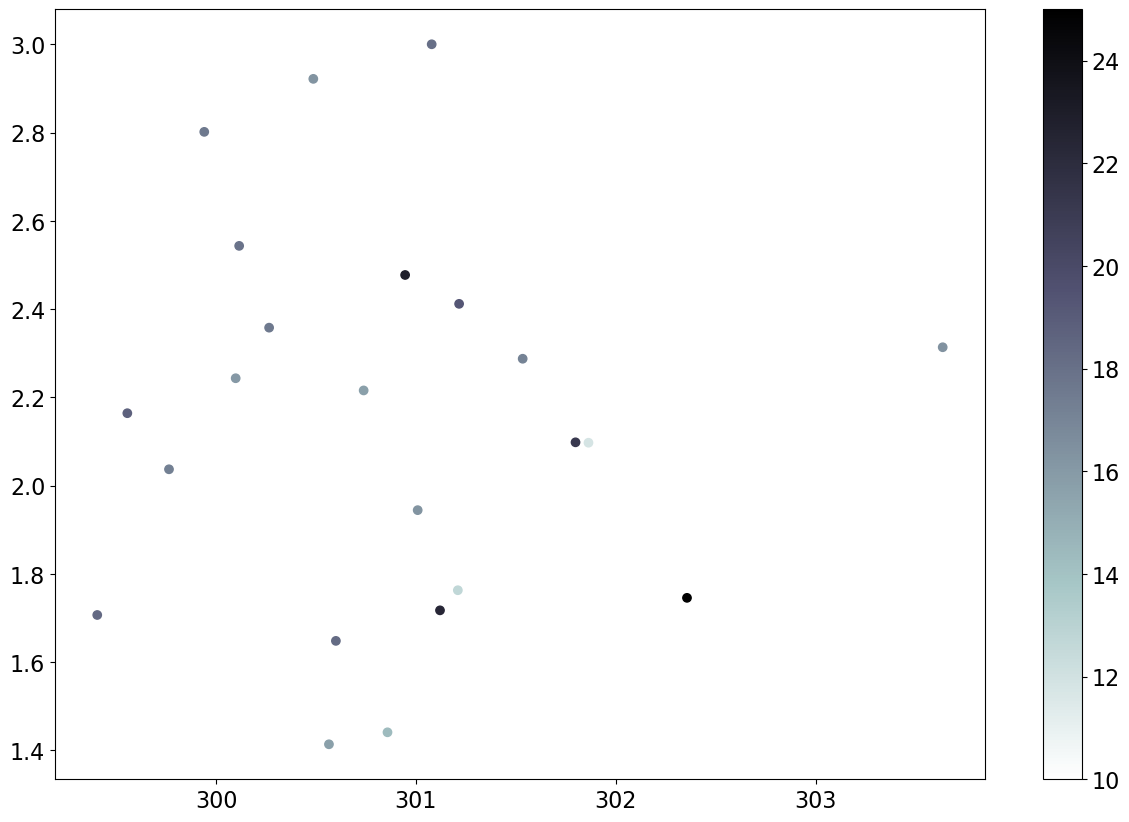

In [65]:
plt.scatter(dd.sst_rms, dd.B_hol, c=abs(dd.lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
plt.colorbar()

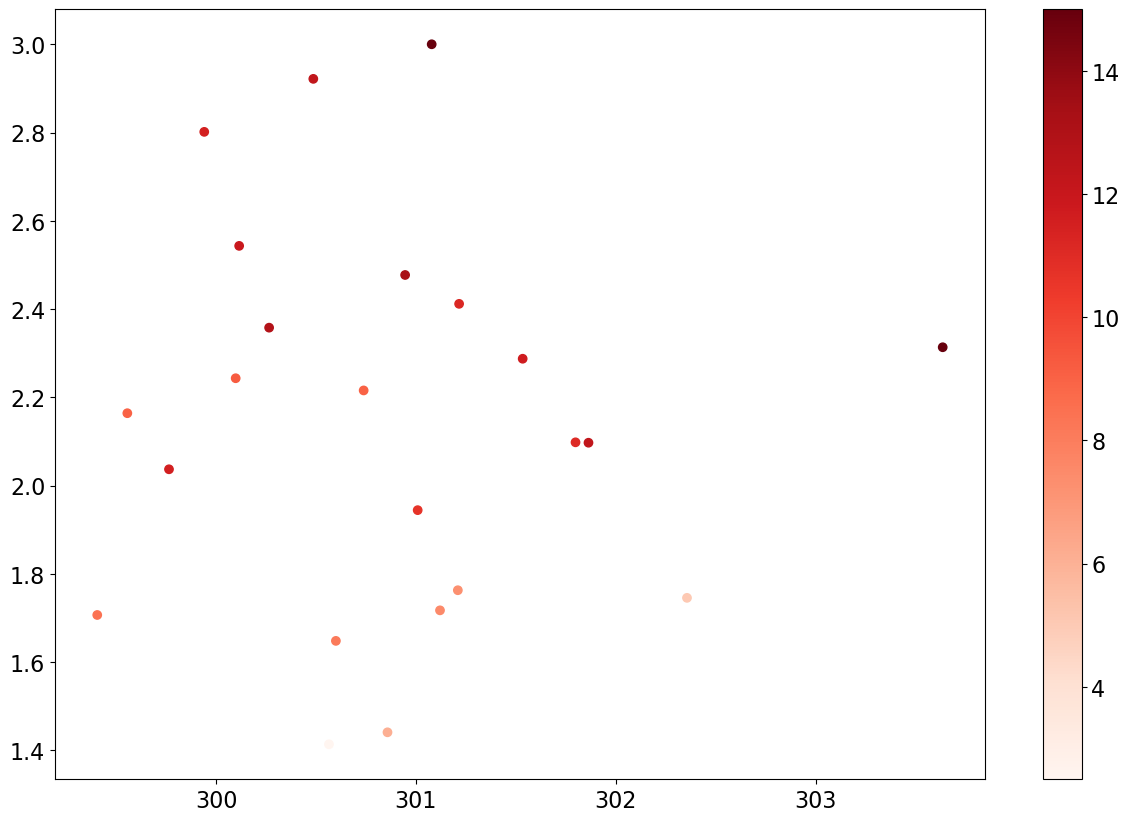

In [72]:
plt.scatter(dd.sst_rms, dd.B_hol, c=abs(dd.vmn_hol), vmin=2.5, vmax=15, cmap=plt.get_cmap('Reds'))
plt.colorbar()

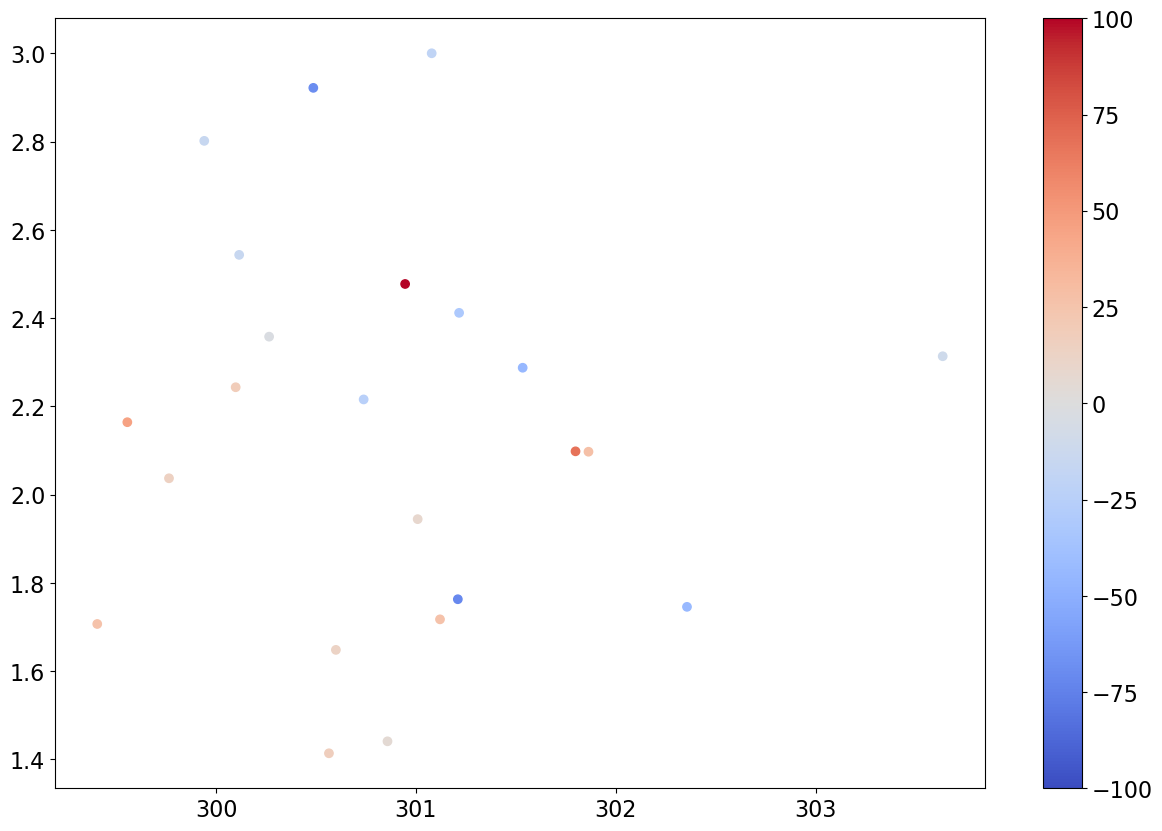

In [81]:
plt.scatter(dd.sst_rms, dd.B_hol, c=dd.t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm'))
plt.colorbar()

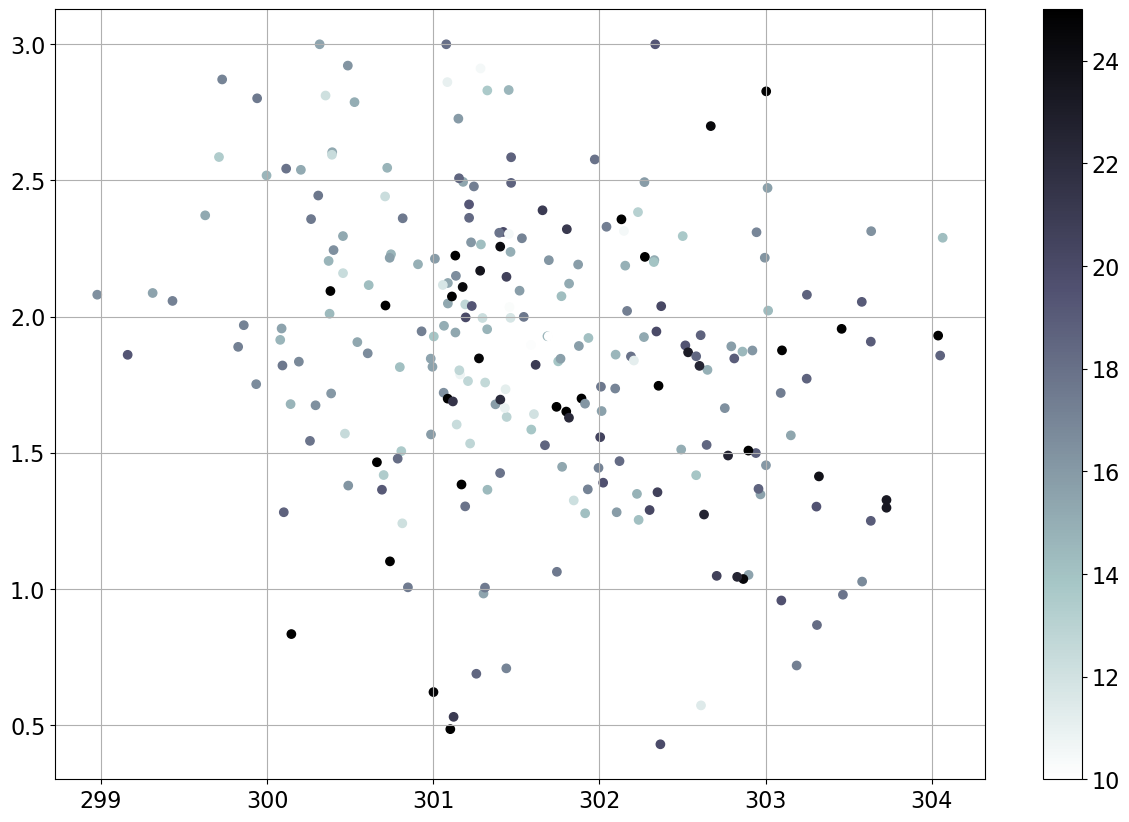

In [82]:
plt.scatter(d.where(d.t_since_lmi_ibt < 0).sst_rms, d.where(d.t_since_lmi_ibt < 0).B_hol, c=abs(d.where(d.t_since_lmi_ibt < 0).lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
plt.grid()
plt.colorbar()
plt.show()

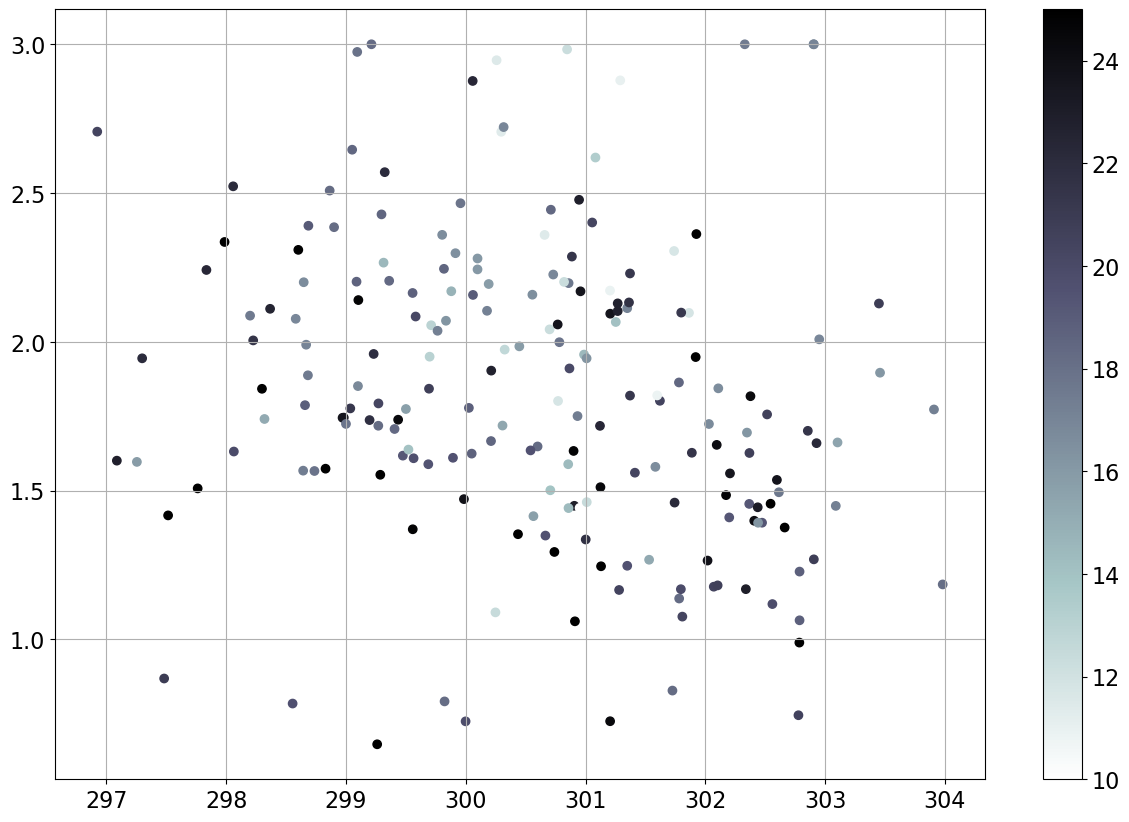

In [85]:
plt.scatter(d.where(d.t_since_lmi_ibt > 0).sst_rms, d.where(d.t_since_lmi_ibt > 0).B_hol, c=abs(d.where(d.t_since_lmi_ibt > 0).lat), vmin=10, vmax=25, cmap=plt.get_cmap('bone_r'))
plt.grid()
plt.colorbar()
plt.show()

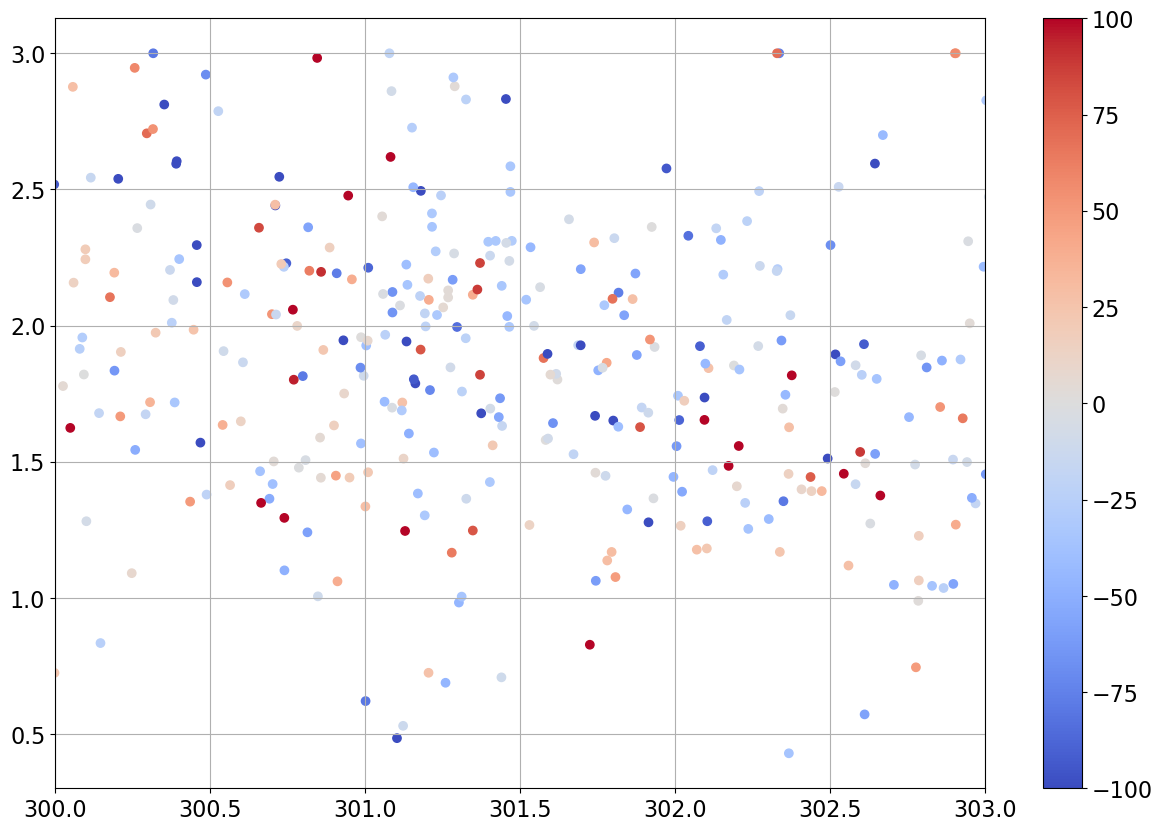

In [91]:
plt.scatter(d.sst_rms, d.B_hol, c=d.t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm'))
plt.grid()
plt.colorbar()
plt.xlim(300, 303)
plt.show()

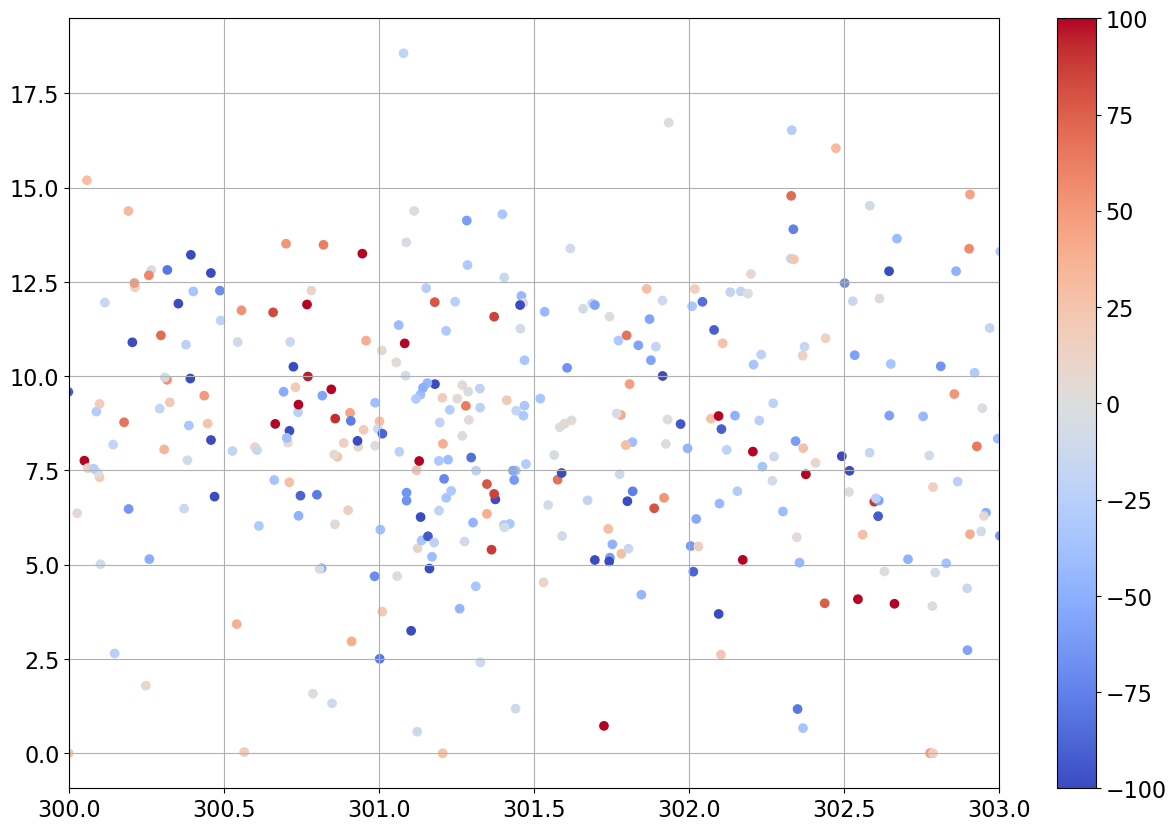

In [94]:
plt.scatter(d.sst_rms, d.vmn_hol, c=d.t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm'))
plt.grid()
plt.colorbar()
plt.xlim(300, 303)
plt.show()

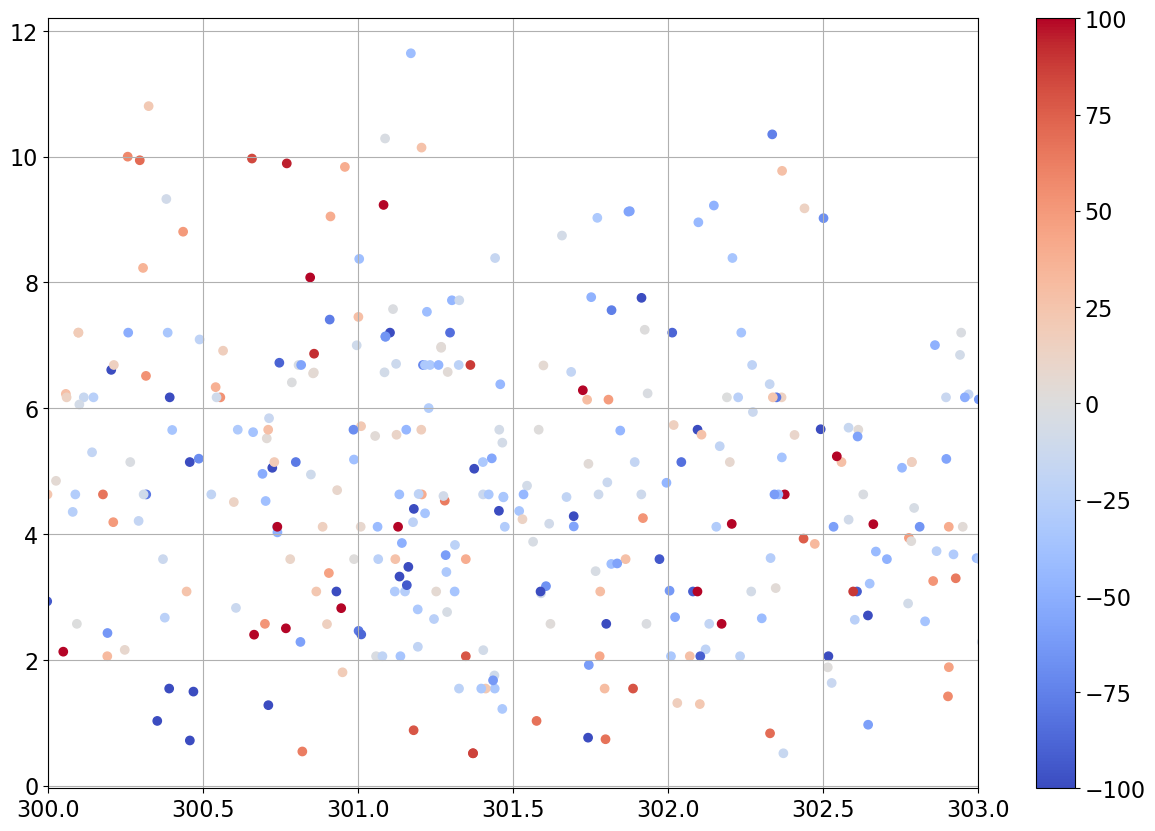

In [101]:
plt.scatter(d.sst_rms, d.storm_speed_ibt, c=d.t_since_lmi_ibt / 3600, vmin=-100, vmax=100, cmap=plt.get_cmap('coolwarm'))
plt.grid()
plt.colorbar()
plt.xlim(300, 303)
plt.show()